In [1]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import SpectralEmbedding
from pytorch_model_summary import summary
from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from scipy.special import iv
from typing import Optional
from matplotlib import cm
import scipy.sparse as sp
import networkx as nx  # pakage for handling a graph
import os.path as osp
from tqdm import tqdm
from scipy import io
import pandas as pd
import numpy as np
import cupy as cp
import easydict
import natsort
import random
import copy
import time
import math
import sys
import os

from torch.distributions.categorical import Categorical
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
import torch


from torch_geometric.utils import sort_edge_index, degree, add_remaining_self_loops, remove_self_loops, get_laplacian, \
    to_undirected, to_dense_adj, to_networkx
from torch_geometric.nn import GCNConv, SGConv, SAGEConv, GATConv, GraphConv, GINConv
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import degree, to_undirected
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import ChebConv, GCNConv
from torch_geometric.datasets import KarateClub


from torch_scatter import scatter
import torch_sparse

# utils

In [2]:
def get_seed_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/user/users/dhkim/eer/SSLGCN',
        'seed_data_dir_path' : 'dataset/seed/SEED_EEG/ExtractedFeatures/data/',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seed_label_dir_path' : 'dataset/seed/SEED_EEG/ExtractedFeatures/label/',
        'figure_save_path' : 'store_seed/figure/',
        'tensor_save_path' : 'store_seed/tensor/',
        'model_save_path' : 'store_seed/model/',
        
        # arguments for counts
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 15,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 10182,
        'n_labels_by_trials1' : 4,
        'n_labels_by_trials2' : 6,
        'n_labels_by_trials3' : 8,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 3394, #721
        'psd_k' : 3394, #1861
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_hid_channels' : 256,
        'gcn_out_channels' : 128,
        'out_channels' : 3,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 32,
        'ptau' : 32,
        'pf1' : 0.1,
        'pf2' : 0.1,
        'pe1' : 0.1,
        'pe2' : 0.1,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def get_seedIV_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'de_LDS',
        'feature_name2' : 'psd_LDS',
        'seedIV_data_dir_path' : 'dataset/seed_IV/eeg_feature_smooth/',
        'figure_save_path' : 'store_seedIV/figure/',
        'tensor_save_path' : 'store_seedIV/tensor/',
        'model_save_path' : 'store_seedIV/model/',
        
        # arguments for counts
        'n_subjects' : 15,
        'n_sessions' : 3,
        'n_trials' : 24,
        'n_nodes' : 62,
        'n_features' : 5,
        'n_samples' : 2505,
        'n_labels_by_class1' : 15,
        'n_labels_by_class2' : 20,
        'n_labels_by_class3' : 25,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 626,
        'psd_k' : 626,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 620,
        'gcn_hid_channels' : 256,
        'gcn_out_channels' : 64,
        'out_channels' : 4,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    return args
    


def get_deap_args():
    args = easydict.EasyDict({
        # arguments for setting device
        'bus_id' : 'PCI_BUS_ID',
        'cuda_id' : ['0','1','2'],
        
        # arguments for path
        'os_path' : '/home/neuroai/users/dhkim/eer/SSLGCN',
        'feature_name1' : 'PSD_LDS_data',
        'feature_name2' : 'DE_LDS_data',
        'deap_label_dir_path' : 'dataset/deap/data_preprocessed_matlab/',
        'deap_data_dir_path' : 'dataset/deap/extractedfeatures/de_psd_lds/',
        'figure_save_path' : 'store_deap/figure/',
        'tensor_save_path' : 'store_deap/tensor/',
        'model_save_path' : 'store_deap/model/',
        'valence' : 'Valence',
        'arousal' : 'Arousal',

        
        # arguments for counts
        'n_subjects' : 32,
        'n_trials' : 40,
        'n_nodes' : 32,
        'n_features' : 4,
        'n_samples' : 2520,
        'n_labels_by_class' : 60,
        'n_labels' : 2,

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 1200,
        'psd_k' : 1200,
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'feature_dimension' : 256,
        'gcn_hid_channels' : 128,
        'gcn_out_channels' : 64,
        'out_channels' : 2,
        'learning_rate' : 0.01,
        'l2_lambda' : 0.001,
        'epochs' : 3000,
        'proj_hid_channels' : 16,
        'ptau' : 0.7,
        'pf1' : 0.1,
        'pf2' : 0.2,
        'pe1' : 0.1,
        'pe2' : 0.2,
        'tpf1' : 0.7,
        'tpf2' : 0.7,
        'tpe1' : 0.7,
        'tpe2' : 0.7,
        'loss_lambda' : 0.01,
        'patience' : 10,
        'val_split' : 0.2
    })
    
    return args

def setting_os_path(path):
    if os.getcwd() != path:
        os.chdir(path)
    return

def get_device(bus_id, cuda_id):
    os.environ["CUDA_DEVICE_ORDER"]= bus_id  # Arrange GPU devices starting from 0
    os.environ["CUDA_VISIBLE_DEVICES"]= cuda_id  # Set the GPU 2 to use
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('Device:', device)
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())
    
    return device
    
def fix_random_variables(seed):
    random.seed(seed)
    np.random.seed(seed)
    cp.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore
    
    return

    
def model_summary(model, fake_input,device):
    print(summary(model, fake_input.to(device), max_depth=True, show_parent_layers=True))
    print(model)
    return

def get_graph_data(features, edge_weights, labels):
    adj = normalize_adj(edge_weights)
    adj = (adj - adj.min()) / (adj.max()-adj.min())
    adj = torch.from_numpy(adj).to(torch.float64)
    features = features[0]
    features = torch.from_numpy(features).to(torch.float64)
    sparse_graph = adj.to_sparse()
    
    labels = torch.from_numpy(labels).to(torch.long)
    data = Data(x=features, edge_index = sparse_graph._indices().to(torch.long), edge_attr =sparse_graph._values(), y=labels)
    return data

def get_base_model(name: str):
    def gat_wrapper(in_channels, out_channels):
        return GATConv(
            in_channels=in_channels,
            out_channels=out_channels // 4,
            heads=4
        )

    def gin_wrapper(in_channels, out_channels):
        mlp = nn.Sequential(
            nn.Linear(in_channels, 2 * out_channels),
            nn.ELU(),
            nn.Linear(2 * out_channels, out_channels)
        )
        return GINConv(mlp)

    base_models = {
        'GCNConv': GCNConv,
        'SGConv': SGConv,
        'SAGEConv': SAGEConv,
        'GATConv': gat_wrapper,
        'GraphConv': GraphConv,
        'GINConv': gin_wrapper
    }

    return base_models[name]


def get_activation(name: str):
    activations = {
        'relu': F.relu,
        'hardtanh': F.hardtanh,
        'elu': F.elu,
        'leakyrelu': F.leaky_relu,
        'prelu': torch.nn.PReLU(),
        'rrelu': F.rrelu,
        'celu' : torch.nn.CELU(),
        'selu' : torch.nn.SELU(),
        'gelu' : torch.nn.GELU()
    }

    return activations[name]


def compute_pr(edge_index, damp: float = 0.85, k: int = 10):
    num_nodes = edge_index.max().item() + 1
    deg_out = degree(edge_index[0])
    x = torch.ones((num_nodes, )).to(edge_index.device).to(torch.float64)

    for i in range(k):
        edge_msg = x[edge_index[0]] / deg_out[edge_index[0]]
        agg_msg = scatter(edge_msg, edge_index[1], reduce='sum')

        x = (1 - damp) * x + damp * agg_msg

    return x


def eigenvector_centrality(data):
    graph = to_networkx(data)
    x = nx.eigenvector_centrality_numpy(graph)
    x = [x[i] for i in range(data.num_nodes)]
    return torch.tensor(x, dtype=torch.float64).to(data.edge_index.device)


def generate_split(num_samples: int, train_ratio: float, val_ratio: float):
    train_len = int(num_samples * train_ratio)
    val_len = int(num_samples * val_ratio)
    test_len = num_samples - train_len - val_len

    train_set, test_set, val_set = random_split(torch.arange(0, num_samples), (train_len, test_len, val_len))

    idx_train, idx_test, idx_val = train_set.indices, test_set.indices, val_set.indices
    train_mask = torch.zeros((num_samples,)).to(torch.bool)
    test_mask = torch.zeros((num_samples,)).to(torch.bool)
    val_mask = torch.zeros((num_samples,)).to(torch.bool)

    train_mask[idx_train] = True
    test_mask[idx_test] = True
    val_mask[idx_val] = True

    return train_mask, test_mask, val_mask


# data

In [3]:
   
def load_deap_data(data_dir_path : str, fname1 : str, fname2 : str, label_dir_path : str, n_columns = 2):
    print("*********** Load features and labels ************")
    
    subject_feature_list1  = np.array([], dtype = float)
    subject_feature_list2  = np.array([], dtype = float)
    subject_label_list = np.array([], dtype = float)
    subject_sample_counts  = np.array([], dtype = int)
    
    feature_dir_list = os.listdir(data_dir_path)

    for feature_idx, feature_dir in enumerate(feature_dir_list):
        feature_data_dir_path = data_dir_path + feature_dir +'/'
        file_list = os.listdir(feature_data_dir_path)
        
        feature_list = np.array([], dtype = float)
        if feature_idx == 0:
            feature_name = fname1
        else:
            feature_name = fname2
        
        for f_idx, file in enumerate(file_list):
            
            data = io.loadmat(feature_data_dir_path + file)
            np_data = data[feature_name]
            
            swap_data = np_data.transpose(1,2,3,0)
            shape = swap_data.shape
            swap_data = swap_data.reshape((shape[0]*shape[1], shape[2], shape[3]))

            if feature_list.size == 0:
                feature_list = swap_data.copy()
                feature_list = np.expand_dims(feature_list, axis=0)
            else:
                feature_list = np.vstack((feature_list, np.expand_dims(swap_data, axis=0)))
                
        if feature_idx == 0:
            print("get data in {} ... done".format(feature_name))
            subject_feature_list1 = feature_list

        else:
            print("get data in {} ... done".format(feature_name))
            subject_feature_list2 = feature_list
            
    label_list = os.listdir(label_dir_path)
    
    shape2 = subject_feature_list1.shape
    print("get label ... ", end= '')
    subject_label_list = np.zeros((shape2[0],shape2[1],n_columns))
    for l_idx, file in enumerate(label_list):
        label = io.loadmat(label_dir_path + file)
        np_label = label['labels'][:,:n_columns]
        start, end, idx = 0, 0, 0
        for row in np_label:
            end += shape[1]
            label_by_trial = np.full((shape[1],n_columns), np_label[idx])
            subject_label_list[l_idx][start:end,:] = label_by_trial
            start = end
            idx += 1
            
    print("done")
    return subject_feature_list1, subject_feature_list2, subject_label_list
    
    
# EEG_band : delta, theta, alpha, beta, gamma, all = 1,2,3,4,5,None
# Feature_name : de_LDS, PSD_LDS, etc.
def load_seedIV_data(data_dir_path : str, feature_name : str, trial : int, islabel=True):
    print("*********** Load features and labels ************")
    print("Feature type : ", feature_name)
    
    subject_feature_list  = np.array([], dtype = float)
    session_dir_list = os.listdir(data_dir_path)
    
    if islabel:
        subject_label_list = np.array([], dtype = float)
        subject_sample_counts  = np.array([], dtype = int)

        label_order = np.array([[1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3],
                           [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1],
                           [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]])
        
        for ses_idx, ses_dir in enumerate(session_dir_list):
            session_feature_list, session_label_list, session_sample_counts = np.array([], dtype = float), np.array([], dtype = int), np.array([], dtype = int)
            
            ses_data_dir_path = data_dir_path + ses_dir +'/'
            file_list = os.listdir(ses_data_dir_path)
            
            for f_idx, file in enumerate(file_list):
                trial_feature_list, trial_label_list, trial_sample_counts = np.array([], dtype = float), np.array([], dtype = int), np.array([], dtype = int)
                
                data = io.loadmat(ses_data_dir_path + file)
                
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:,:,:]
                    swap_data = np_data.transpose(1,2,0)
                    
                    if trial_feature_list.size == 0:
                        trial_feature_list = swap_data.copy()
                    else:
                        trial_feature_list = np.vstack((trial_feature_list, swap_data))
                    
                    trial_label = np.full((swap_data.shape[0]), label_order[ses_idx][trial_idx-1])
                    trial_label_list = np.hstack((trial_label_list, trial_label))
                    
                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))
                
                if session_feature_list.size == 0:
                    session_feature_list = np.expand_dims(trial_feature_list.copy(), axis=0)
                else:
                    session_feature_list = np.vstack((session_feature_list, np.expand_dims(trial_feature_list, axis=0)))

                if session_label_list.size ==0:
                    session_label_list = np.expand_dims(trial_label_list.copy(), axis=0)
                else:
                    session_label_list = np.vstack((session_label_list, np.expand_dims(trial_label_list, axis=0)))

                if session_sample_counts.size == 0:
                    session_sample_counts = np.expand_dims(trial_sample_counts.copy(), axis=0)
                else:
                    session_sample_counts = np.vstack((session_sample_counts, trial_sample_counts))
                    
            if subject_feature_list.size == 0:
                subject_feature_list = session_feature_list
            else:
                subject_feature_list = np.concatenate((subject_feature_list, session_feature_list),axis = 1)
            
            if subject_label_list.size == 0:
                subject_label_list = session_label_list
            else:
                subject_label_list = np.concatenate((subject_label_list, session_label_list),axis = 1)
                
            if subject_sample_counts.size == 0:
                subject_sample_counts = session_sample_counts
            else:
                subject_sample_counts= np.concatenate((subject_sample_counts, session_sample_counts),axis = 1)

            print("get data in session {} ... done".format(ses_idx+1))
        return subject_feature_list, subject_label_list, subject_sample_counts
    
    else:
        for ses_idx, ses_dir in enumerate(session_dir_list):
            session_feature_list = np.array([], dtype = float)
            
            ses_data_dir_path = data_dir_path + ses_dir +'/'
            file_list = os.listdir(ses_data_dir_path)
            
            for f_idx, file in enumerate(file_list):
                trial_feature_list = np.array([], dtype = float)
                
                data = io.loadmat(ses_data_dir_path + file)
                
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:,:,:]
                    swap_data = np_data.transpose(1,2,0)
                    
                    if trial_feature_list.size == 0:
                        trial_feature_list = swap_data.copy()
                    else:
                        trial_feature_list = np.vstack((trial_feature_list, swap_data))
                    
                if session_feature_list.size == 0:
                    session_feature_list = np.expand_dims(trial_feature_list.copy(), axis=0)
                else:
                    session_feature_list = np.vstack((session_feature_list, np.expand_dims(trial_feature_list, axis=0)))
                    
            if subject_feature_list.size == 0:
                subject_feature_list = session_feature_list
            else:
                subject_feature_list = np.concatenate((subject_feature_list, session_feature_list),axis = 1)
    
            print("get data in session {} ... done".format(ses_idx+1))
        return subject_feature_list
    
    
def load_seed_data(data_dir_path, trial:int, feature_name, label_dir_path = None, EEG_band=None): 

    print("*********** Load features and labels ************")
    
    subject_feature_list, sample_feature_list = np.arange(0, dtype = 'float64'), np.arange(0, dtype = 'float64')
    file_list = natsort.natsorted(os.listdir(data_dir_path))
    
    if label_dir_path != None:
        label_order = io.loadmat(label_dir_path + 'label.mat')['label']
        label_order = [1 + label_order[0][i] for i in range(trial)]
        print("label: {}".format(label_order))
        subject_label_list, sample_label_list= np.array([], dtype = float), np.array([], dtype = float)
        subject_sample_counts, trial_sample_counts = np.array([], dtype = int), np.array([], dtype = int)

        print("Feature type : ", feature_name)
        for idx, file in enumerate(file_list):
            data = io.loadmat(data_dir_path + file)
            print(file)
            if EEG_band is None:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, :]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))

                    trial_label = np.full((swap_data.shape[0]), np.int_(label_order[trial_idx-1])) 
                    sample_label_list = np.hstack((sample_label_list,trial_label))

                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))

            else:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, EEG_band]

                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))


                    trial_label = np.full((swap_data.shape[0]), float(label_order[trial_idx-1])) 
                    sample_label_list = np.hstack((sample_label_list,trial_label))

                    trial_sample_counts = np.hstack((trial_sample_counts, swap_data.shape[0]))

            if (idx+1)%3 == 0:

                if subject_feature_list.size == 0:
                    subject_feature_list = np.expand_dims(sample_feature_list.copy(), axis=0)
                else:
                    subject_feature_list = np.vstack((subject_feature_list, np.expand_dims(sample_feature_list, axis=0)))

                sample_feature_list = np.array([], dtype = 'float64')

                if subject_label_list.size ==0:
                    subject_label_list = np.expand_dims(sample_label_list.copy(), axis=0)
                else:
                    subject_label_list = np.vstack((subject_label_list, np.expand_dims(sample_label_list, axis=0)))
                sample_label_list = np.array([],dtype = 'float64')

                if subject_sample_counts.size == 0:
                    subject_sample_counts = np.expand_dims(trial_sample_counts.copy(), axis=0)
                else:
                    subject_sample_counts = np.vstack((subject_sample_counts, trial_sample_counts))
                trial_sample_counts = np.array([], dtype=int)

                print("get data of subject {} ... done".format(int((idx+1)/3)))
            
        print("\n data loading complete")
        return subject_feature_list, subject_label_list, subject_sample_counts
                
    else:
        print("Feature type : ", feature_name)
        for idx, file in enumerate(file_list):
            print(file)
            data =io.loadmat(data_dir_path + file)
            
            if EEG_band is None:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, :]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))

            else:
                for trial_idx in range(1, trial+1):
                    np_data = data[feature_name + str(trial_idx)][:, :, EEG_band]
                    swap_data = np_data.transpose(1,2,0)

                    if sample_feature_list.size == 0:
                        sample_feature_list = swap_data.copy()
                    else:
                        sample_feature_list = np.vstack((sample_feature_list, swap_data))


            if (idx+1)%3 == 0:

                if subject_feature_list.size == 0:
                    subject_feature_list = np.expand_dims(sample_feature_list.copy(), axis=0)
                else:
                    subject_feature_list = np.vstack((subject_feature_list, np.expand_dims(sample_feature_list, axis=0)))

                sample_feature_list = np.array([], dtype = 'float64')

                print("get data of subject {} ... done".format(int((idx+1)/3)))
                    
        print("\n data loading complete")
        return subject_feature_list
    
    # label [-1, 1] --> [0, 2]
    # subject_feature_list : num_subjects(15) × (num_sessions(3) * num_trials(15) * approximately(240)) x feature embedding dimension(5) * num_nodes(62)


# edge attributes are composed of edge weights, the distance between all EEG channel pairs

def flatten(arr, reshape_size):
    if isinstance(arr, list):
        flatten_feature = np.array(arr).reshape((-1, reshape_size))
    elif isinstance(arr, np.ndarray):
        flatten_feature = arr.reshape((-1, reshape_size))
    else:
        print("unavailable type")
    return flatten_feature


def deap_label(label_list):
        
    def binary_label_generator(val):
        if val < 5.:
            return 0
        else:
            return 1
            
    shape = label_list.shape
    valence_values = label_list[:,0]
    arousal_values = label_list[:,1]
    
    vlc_label = np.zeros(shape[0])
    ars_label = np.zeros(shape[0])
    
    for i in range(shape[0]):
        vlc_label[i] = binary_label_generator(valence_values[i])
        ars_label[i] = binary_label_generator(arousal_values[i])
    
    print("************* The number of samples by class ***********")
    print("Threshold : 5.0")
    print("low valence : {},    high valence : {}".format(np.where(vlc_label == 0)[0].shape, np.where(vlc_label == 1)[0].shape))
    print("low arousal : {},    high arousal : {}".format(np.where(ars_label == 0)[0].shape, np.where(ars_label == 1)[0].shape))
    
    return vlc_label, ars_label

def preprocessing(feature_list, sample_count_list, n_samples, n_labels_by_trials, n_nodes, n_features, seed): # flattening and simultaneous random shuffling
    labeled_data_identifier = np.zeros(n_samples)
    start = 0
    end = 0
    random.seed(seed)
    for num in sample_count_list:
        end += num
        idcs = random.sample(range(start,end-1), n_labels_by_trials)
        labeled_data_identifier[idcs] = 1
        start += num
        
    flattened_feature_list = flatten(feature_list, n_nodes*n_features)

    return flattened_feature_list, labeled_data_identifier

def other_preprocessing(f1, f2, label_list, n_labels_by_class, n_classes,seed, isdeap=False): # flattening and simultaneous random shuffling
    shape = f1.shape
    n_samples = shape[0]
    n_features = shape[1]
    n_nodes = shape[2]

    ff1 = flatten(f1,n_features*n_nodes)
    ff2 = flatten(f2,n_features*n_nodes)

    random.seed(seed)

    if isdeap == True:
        vlc_label = label_list[0]
        ars_label = label_list[1]
        
        vlc_labeled_data_identifier = np.zeros(n_samples)
        ars_labeled_data_identifier = np.zeros(n_samples)

        for i in range(n_classes):
            indices = np.where(vlc_label == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            vlc_labeled_data_identifier[labeled_idx] = 1

        for i in range(n_classes):
            indices = np.where(ars_label == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            ars_labeled_data_identifier[labeled_idx] = 1

        return ff1,ff2,vlc_labeled_data_identifier, ars_labeled_data_identifier

    else:
        labeled_data_identifier = np.zeros(n_samples)
        for i in range(n_classes):
            indices = np.where(label_list == i)[0]
            labeled_idx = random.sample(sorted(indices), n_labels_by_class)
            labeled_data_identifier[labeled_idx] = 1

        return ff1,ff2,labeled_data_identifier

# functionals

In [4]:

# PCA was already implemented, LDA and NCA will be implemented later.
def dimensionality_reduction(feature_list, n_component, feature_name, sub_idx, date): # PCA
    feature_list = StandardScaler().fit_transform(feature_list) # standardization

    pca = PCA(n_components = n_component)
    pComponents = pca.fit_transform(feature_list)
    print("Explaned variance ratio by principal components :", pca.explained_variance_ratio_, "\n Overall ratio: ",sum(pca.explained_variance_ratio_))

    save_pca_figure(pca.explained_variance_ratio_, n_component, feature_name, sub_idx, date)
    
    return pComponents, pca.explained_variance_ratio_


def input_feature(f1, f2):
    return np.concatenate((f1,f2), axis = 1)


def distance_matrix(f1):
    shape = f1.shape[0]
    if shape>5000:
        D = np.zeros((shape,shape),float)
        for i in range(shape):
            for j in range(i+1, shape):
                dist = np.linalg.norm(f1[i,:] - f1[j,:])
                D[i,j] = dist
        D += D.T
        return D
    else:
        pairwise_dist = np.sum((f1[:, np.newaxis, :] - f1[np.newaxis, :, :])**2, axis=-1)

        # Return square root of pairwise distances to obtain Euclidean distance
        euclidean_dist = np.sqrt(pairwise_dist)
        return euclidean_dist


# get indices of K-nearest neighbors based on Manhattan distance of pivotal element of ssm 
def kneighbors(distance_matrix, length, k):
    neighbors = np.zeros((length, k), dtype = float)
    
    neigh = NearestNeighbors(n_neighbors = k, p=1)
    for i, vector in enumerate(distance_matrix):
        v = np.expand_dims(vector,axis = 1)
        neigh.fit(v)
        neighbor= neigh.kneighbors([[vector[i]]], return_distance=False)
        neighbors[i] = neighbor.squeeze()
    neighbors = neighbors.astype(dtype='int32')
    return neighbors


def ssm_construction(dm, neighbors):
    print("\n********** SSM construction start ***********")
    length=dm.shape[0]
    ssm = np.zeros((length, length), dtype = 'float64')
    normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')

    scaled_distance_mean = -dm.mean()*0.05
    print("Done")
    print("\nSparse ssm and normalized sparse ssm construction start...")
    # construct sparse_ssm 
    for i in range(length):
        ith_neigh = neighbors[i]
        ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
        ssm[i,ith_neigh] = ssm_elements
    ssm = ssm+ssm.T-np.diag(ssm.diagonal())
        
#         ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
#         if ssm_sum != 0:
#             normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.5
    
#     print("Done\n")

#     trium = np.triu(normalized_sparse_ssm, k=1)
#     normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())

    normalized_sparse_ssm = normalize_ssm(ssm)
    print("Done\n")
    
    return ssm, normalized_sparse_ssm

# def ssm_construction(feature_list, length, k):
#     print("\n********** SSM construction start ***********")
#     ssm = np.zeros((length, length), dtype = 'float64')
#     normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
#     print("\nDistance matrix construction start...")
#     dm = distance_matrix(feature_list)

#     scaled_distance_mean = -dm.mean()*0.05
#     neighbors = kneighbors(dm, length, k)
#     print("Done")
#     print("\nSparse ssm and normalized sparse ssm construction start...")
#     # construct sparse_ssm 
#     for i in range(length):
#         ith_neigh = neighbors[i]
#         ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
#         ssm[i,ith_neigh] = ssm_elements
#         ssm[ith_neigh,i] = ssm_elements
        
#         ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
#         if ssm_sum != 0:
#             normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.5
#     normalize_adj(ssm)
    
#     print("Done\n")

#     trium = np.triu(normalized_sparse_ssm, k=1)
#     normalized_sparse_ssm = trium + trium.T + np.diag(normalized_sparse_ssm.diagonal())

#     print("Done\n")
    
#     return ssm, normalized_sparse_ssm

# def ssm_construction(feature_list, length, k):
#     print("\n********** SSM construction start ***********")
#     ssm = np.zeros((length, length), dtype = 'float64')
#     normalized_sparse_ssm = np.zeros((length,length), dtype = 'float64')
    
#     print("\nDistance matrix construction start...")
#     dm = distance_matrix(feature_list)

#     scaled_distance_mean = -dm.mean()*0.05
#     neighbors = kneighbors(dm, length, k)
#     print("Done")
#     print("\nSparse ssm and normalized sparse ssm construction start...")
#     # construct sparse_ssm 
#     for i in range(length):
#         ith_neigh = neighbors[i]
#         ssm_elements = np.exp(dm[i][ith_neigh]/scaled_distance_mean)
#         ssm[i,ith_neigh] = ssm_elements
        
#         ssm_sum = 2.0*(np.sum(ssm_elements)-1.)
#         if ssm_sum != 0:
#             normalized_sparse_ssm[i][ith_neigh] = ssm_elements / ssm_sum
#         normalized_sparse_ssm[i][i] = 0.5

#     print("Done\n")
    
#     return ssm, normalized_sparse_ssm

def ssm_fusion(ssm_1,ssm_2,nssm_1,nssm_2, k, t):
    print("\n********** SSM fusion start ***********")
    length = ssm_1.shape[0]
    
    skm_1 = np.zeros((length,length), dtype = 'float64') # km means kernel matrix
    skm_2 = np.zeros((length,length), dtype = 'float64')
    
    f1_neighbors = kneighbors(ssm_1, length, k)
    f2_neighbors = kneighbors(ssm_2, length, k)
    
    print("sparse kernel matrix construction start...")
    # 1st feature based sparse kernel matrix construction 
    for i in range(length):
        f1_ith_neighs = f1_neighbors[i]
        f1_elements = ssm_1[i][f1_ith_neighs]
        skm_1[i,f1_ith_neighs] = f1_elements
        
        f2_ith_neighs = f2_neighbors[i]
        f2_elements = ssm_2[i][f2_ith_neighs]
        skm_2[i,f2_ith_neighs] = f2_elements
        
    
    skm_1 = normalize_ssm(skm_1+skm_1.T-np.diag(skm_1.diagonal()))
    skm_2 = normalize_ssm(skm_2+skm_2.T-np.diag(skm_2.diagonal()))
    print("1st feature based skm has been completed")
    print("2nd feature based skm has been completed\n")
    
    print("fused ssm construction start...")
    # make normalized weight matrices by iterating t times
    
    st=time.time()
    
    for _t in range(t):
        print("time step : ",_t)
        temp = nssm_1.copy()
        nssm_1 = np.matmul(np.matmul(skm_1, nssm_2.copy()), skm_1)
        nssm_2 = np.matmul(np.matmul(skm_2, temp), skm_2)
        if(t>1 and _t<t-1):
            nssm_1 = normalize_ssm(nssm_1)
            nssm_2 = normalize_ssm(nssm_2)
    
    fused_ssm = (nssm_1 + nssm_2) / 2

    print(f"{time.time()-st:.4f} sec") # 종료와 함께 수행시간 출력
    print("Done")
    print("**********************************************")
    return fused_ssm

# def ssm_fusion(ssm_1,ssm_2,nssm_1,nssm_2, k, t):
#     print("\n********** SSM fusion start ***********")
#     length = ssm_1.shape[0]
    
#     skm_1 = np.zeros((length,length), dtype = 'float64') # km means kernel matrix
#     skm_2 = np.zeros((length,length), dtype = 'float64')
    
#     f1_neighbors = kneighbors(ssm_1, length, k)
#     f2_neighbors = kneighbors(ssm_2, length, k)
    
#     print("sparse kernel matrix construction start...")
#     # 1st feature based sparse kernel matrix construction 
#     for i in range(length):
#         f1_ith_neighs = f1_neighbors[i]
#         skm_1[i][f1_ith_neighs] = ssm_1[i][f1_ith_neighs]/np.sum(ssm_1[i][f1_ith_neighs])
        
#         f2_ith_neighs = f2_neighbors[i]
#         skm_2[i][f2_ith_neighs] = ssm_2[i][f2_ith_neighs]/np.sum(ssm_2[i][f2_ith_neighs])
#     print("1st feature based skm has been completed")
#     print("2nd feature based skm has been completed\n")
    
#     print("fused ssm construction start...")
#     # make normalized weight matrices by iterating t times
    
#     st=time.time()
    
#     for _t in range(t):
#         print("time step : ",_t)
#         temp = nssm_1.copy()
#         nssm_1 = np.matmul(np.matmul(skm_1, nssm_2.copy().T), skm_1.T)
#         nssm_2 = np.matmul(np.matmul(skm_2, temp.T), skm_2.T)
            
#     fused_ssm = (nssm_1 + nssm_2) / 2

#     print(f"{time.time()-st:.4f} sec") # 종료와 함께 수행시간 출력
#     print("Done")
#     print("**********************************************")
#     return fused_ssm

def neighbor_matrix(neighbors,length,n_neigh):
    i_neigh = np.zeros((length,n_neigh**2), dtype=float)
    j_neigh = np.zeros((length,n_neigh**2), dtype=float)
    for i in range(length):
        duplicate_neighbors = sorted(list(neighbors[i]))*n_neigh
        j_neigh[i] = duplicate_neighbors
        i_neigh[i] = sorted(duplicate_neighbors)
    return i_neigh, j_neigh

def process_diffusion(fused_ssm, dfssm, i_neigh, j_neigh, neighbors,k2,t2, rweight, length):
    # construct enhanced ssm leveraging "fused ssm (fused_ssm)" and "denoised fused ssm (dfssm)"
    print("\nSSM enhancement start...")
    enhanced_ssm = cp.zeros((length, length), dtype = 'float64')

    neighbors = neighbors.astype(dtype='int32')
    neighbors = np.sort(neighbors, axis=1)
    ci_neigh = cp.asarray(i_neigh, dtype='int32')
    cj_neigh = cp.asarray(j_neigh, dtype='int32')

    essm = fused_ssm.copy()

    for _t2 in range(t2):
        for i in range(length):
            ith_neigh = neighbors[i]
            Qi = dfssm[i,ith_neigh]
            vstacks = cp.random.random((k2,), dtype=float)
            c_ith_neigh = ci_neigh[i]
            for j in range(length):
                A = essm[c_ith_neigh,cj_neigh[j]].reshape((k2,k2))
                Qj = dfssm[neighbors[j],j]
                vstacks = cp.vstack((vstacks,cp.matmul(A,Qj)))
            vstacks = vstacks[1:].T
            ith_essm = cp.matmul(Qi, vstacks)
            enhanced_ssm[i,:] = ith_essm
        essm = (rweight*enhanced_ssm + (1.0-rweight)*dfssm).copy()

    print("Done")
    print("*********************************************")
    essm = cp.asnumpy(essm)
    return essm


def ssm_enhancement(fused_ssm,k2, t2, rweight):
    print("\n********** SSM enhancement start ***********")
    length = fused_ssm.shape[0]
    
    neighbors = kneighbors(fused_ssm, length, k2)
    
    print("\nLocalized fused ssm construction start...")
    # construct the localized fused ssm by using KNN
    lfssm = cp.zeros((length, length), dtype = 'float64') # nfssm means knn based "normalized fused ssm"
    fused_ssm = cp.asarray(fused_ssm)
    for i in range(length):
        ith_neighs = neighbors[i]
        lfssm[i][ith_neighs] = fused_ssm[i][ith_neighs] / cp.sum(fused_ssm[i][ith_neighs])
    
    print("Done\n")
    print("Denoised fused ssm construction start...")
    # construct the denoised fused ssm exploiting nfssm
    dfssm = cp.zeros((length,length), dtype = 'float64') # dfssm means denoised fused ssm
    
    sum_lfssm = cp.sum(lfssm, axis = 0)
    # upper trianluar matrix construction
    for i in range(length):
        for j in range(i,length):
            dfssm[i][j] = cp.sum(lfssm[i,:]*lfssm[j,:]/sum_lfssm)
    
    # reconstruct above matrix to symmetric matrix
    dfssm += dfssm.T - cp.diag(dfssm.diagonal())
    
    print("Done\n")
    
    print("\n Generate table for neighbors ...")
    i_neigh, j_neigh = neighbor_matrix(neighbors,length,k2)
    print("Done\n")
    
    essm = process_diffusion(fused_ssm, dfssm, i_neigh, j_neigh, neighbors,k2,t2,rweight,length)
    return essm
    

"""
Consider a weight for identity elements later
"""
def normalize_ssm(matrix):
    length = matrix.shape[0]
    tilde_matrix = matrix#+np.identity(length)
    deg = np.sum(tilde_matrix, axis=1)
    norm_deg = np.power(deg,-0.5)
    tilde_deg = np.diag(norm_deg) # degree matrix (D) tilde
    nor_ssm = np.matmul(np.matmul(tilde_deg, tilde_matrix),tilde_deg)
        
    return nor_ssm

def normalize_adj(adj, im):   
    length = adj.size(0)
    tilde_adj = adj + im # adjacency matrix (A) tilde
    deg = torch.sum(tilde_adj, dim=1)
    norm_deg = torch.pow(deg, -0.5)
    tilde_deg = torch.diag(norm_deg)  # degree matrix (D) tilde
    nor_adj = torch.mm(torch.mm(tilde_deg, tilde_adj), tilde_deg)

    
    return nor_adj

def normalization(x:torch.Tensor, axis:int = 0, ntype:str = None) -> torch.Tensor:
    if ntype == None:
        print("ntype is missed -- original tensor is returned")
        return x
    elif ntype == 'standardization':
        return (x-x.mean(axis=axis))/x.std(axis=axis)
    elif ntype == 'min-max':
        return (x - x.min())/(x.max() - x.min())



# models

In [5]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels,
                 seed = 2023,
                 bias = False
                ):
        super(GraphConvolution, self).__init__()
        random.seed(seed)
        np.random.seed(seed)
        cp.random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)  # type: ignore
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True  # type: ignore
        torch.backends.cudnn.benchmark = False  # type: ignore
        
        self.weight = nn.Parameter(torch.empty(in_channels, out_channels))
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.torch.empty(out_channels))
#         else:
#             self.register_parameter('bias',None)
        self.reset_parameters()
        
    def forward(self, x, adj):
        out = torch.mm(x, self.weight)
        out = torch.mm(adj, out)

        if self.bias is not None:
            out += self.bias
        return out
    
    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

class Encoder(nn.Module):
    def __init__(self, in_channels: int, hid_channels: int, out_channels: int, activation, seed, base_model=GraphConvolution):
        super(Encoder, self).__init__()
        self.base_model = base_model

        self.gcn1 = base_model(in_channels, hid_channels, seed, bias = True)
        self.gcn2 = base_model(hid_channels, out_channels, seed, bias = True)

        self.activation = activation

    def forward(self, x: torch.Tensor, edges: torch.Tensor):
        x = x.squeeze()
        x1 = self.activation(self.gcn1(x, edges))
        x2 = self.activation(self.gcn2(x1, edges))
        return x2
#         return torch.cat((x1,x2),axis=1)


class GRACE(nn.Module):
    def __init__(self, encoder: Encoder, num_in: int, num_hidden: int, num_proj_hidden: int, num_out: int, tau: float = 0.5):
        super(GRACE, self).__init__()
        self.encoder: Encoder = encoder
        self.tau: float = tau
        
        self.fc1 = nn.Linear(num_hidden, num_proj_hidden)
        self.fc2 = nn.Linear(num_proj_hidden, num_hidden)

        self.gcn_classifier = GraphConvolution(num_hidden, num_out, 2023, bias=False)
        self.fc_classifier = nn.Linear(num_hidden, num_out)
        self.activation = nn.CELU()
        self.num_hidden = num_hidden
        self.norm1d = nn.BatchNorm1d(num_in)

    def forward(self, x: torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
#         x = self.norm1d(x)
        x = x.unsqueeze(dim=0)
        return self.encoder(x, edges)
    
    def decoder(self, z):
        return self.activation(torch.mm(z, z.t()))
    
    def classification(self, z: torch.Tensor) ->torch.Tensor:
#         return self.gcn_classifier(self.activation(z), adj)
        return self.fc_classifier(self.activation(z))
    
    def projection(self, z: torch.Tensor) -> torch.Tensor:
        z = self.activation(self.fc1(z))
        return self.fc2(z)

    def sim(self, z1: torch.Tensor, z2: torch.Tensor):
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)
        return torch.mm(z1, z2.t())

    def semi_loss(self, z1: torch.Tensor, z2: torch.Tensor):
        f = lambda x: torch.exp(x / self.tau)
        refl_sim = f(self.sim(z1, z1))
        between_sim = f(self.sim(z1, z2))

        return -torch.log(between_sim.diag() / (refl_sim.sum(1) + between_sim.sum(1) - refl_sim.diag()))

    def batched_semi_loss(self, z1: torch.Tensor, z2: torch.Tensor, batch_size: int):
        # Space complexity: O(BN) (semi_loss: O(N^2))
        device = z1.device
        num_nodes = z1.size(0)
        num_batches = (num_nodes - 1) // batch_size + 1
        f = lambda x: torch.exp(x / self.tau)
        indices = torch.arange(0, num_nodes).to(device)
        losses = []

        for i in range(num_batches):
            mask = indices[i * batch_size:(i + 1) * batch_size]
            refl_sim = f(self.sim(z1[mask], z1))  # [B, N]
            between_sim = f(self.sim(z1[mask], z2))  # [B, N]

            losses.append(-torch.log(between_sim[:, i * batch_size:(i + 1) * batch_size].diag()
                                     / (refl_sim.sum(1) + between_sim.sum(1)
                                        - refl_sim[:, i * batch_size:(i + 1) * batch_size].diag())))

        return torch.cat(losses)

    def loss(self, h1: torch.Tensor, h2: torch.Tensor, mean: bool = True, batch_size: Optional[int] = None):

        if batch_size is None:
            l1 = self.semi_loss(h1, h2)
            l2 = self.semi_loss(h2, h1)
        else:
            l1 = self.batched_semi_loss(h1, h2, batch_size)
            l2 = self.batched_semi_loss(h2, h1, batch_size)

        ret = (l1 + l2) * 0.5
        ret = ret.mean() if mean else ret.sum()

        return ret


class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq):
        ret = self.fc(seq)
        return ret

# activation Relu, Gelu, leaky Relu, Elu 비교해보기


class SSLGCN(nn.Module):
    def __init__(self, args, adj):
        super(SSLGCN, self).__init__()
        torch.random.manual_seed(args.seed)
        self.l2_lambda = args.l2_lambda
        self.in_channels = args.pca_components1 + args.pca_components2
        self.gcn_hid_channels = args.gcn_hid_channels
        self.gcn_out_channels = args.gcn_out_channels
        self.fc_in_channels = args.gcn_hid_channels + args.gcn_out_channels
#         self.fc_hid_channels = args.fc_hid_channels
        self.out_channels = args.out_channels
        self.edges = adj
        self.activation = nn.CELU()

        self.norm1d = nn.BatchNorm1d(self.in_channels)
        self.gcnlayer1 = GraphConvolution(self.in_channels, self.gcn_hid_channels,
                             bias = False)
        self.gcnlayer2 = GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
                             bias = False)
#         self.gcnlayers = nn.Sequential(
#             GraphConvolution(self.in_channels, self.gcn_hid_channels,
#                              adj = self.edges,
#                              bias = False),
#             self.activation,
            
#             GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
#                              adj = self.edges,
#                              bias = False),
#             self.activation
#         )
        
        self.fclayer = nn.Linear(self.fc_in_channels, self.out_channels)
#         self.fc1 = nn.Linear(self.fc_in_channels, self.fc_hid_channels)
#         self.fc2 = nn.Linear(self.fc_hid_channels, self.out_channels)
#         self.fclayers = nn.Sequential(self.fc1,self.activation,self.fc2)
        
        
    def forward(self, x):
        x = torch.squeeze(x)
        x = self.norm1d(x)
        gcn_out1 = self.activation(self.gcnlayer1(x,self.edges))
        gcn_out2 = self.activation(self.gcnlayer2(gcn_out1, self.edges))
        gcn_out = torch.cat((gcn_out1, gcn_out2), axis = 1)
        out = self.fclayer(gcn_out)
        return out

    def set_lambda(self, l2_lambda):
        self.l2_lambda = l2_lamda
        
    def l2_regularization(self):
#         gcn_layers = self.gcnlayers.children()
#         gcn_layers = next(iter(gcn_layers)) # Allow parameters to be extracted iteratively
        loss = None
        
        for p in self.gcnlayer1.parameters():
            if loss is None:
                loss = p.pow(2).sum()
            else:
                loss += p.pow(2).sum()
                
        for p in self.gcnlayer2.parameters():
            loss += p.pow(2).sum()
                
#         fc_layers = self.fclayers.children()
#         fc_layers = next(iter(fc_layers)) 
        
        for p in self.fclayer.parameters():
            loss += p.pow(2).sum()
 
        return loss * self.l2_lambda



# learn

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def criterion(out, label):
    return nn.functional.cross_entropy(out, label)

def accuracy(out, label, isbinary = False):
    if isbinary == True:
        out = torch.sigmoid(out)
    else:
        out = nn.functional.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    iscorrect = torch.eq(pred,label).float()
    return iscorrect.mean()*100
    
# Learning rate schedular will be added later

def test(feature, label, test_identifier, model):
    model.eval()
    
    result = model(feature)
    
    test_pred = result[test_identifier]
    test_y = label[test_identifier]
    
    acc = accuracy(test_pred, test_y)
    
    print("Test Acc : ", round(acc.item(), 2))
    
    return result, round(acc.item(), 2)


def GCA_train(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rank = disc_rank(feature, label,train_identifier, args.out_channels)

    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(feature, rank, p = args.pf1, threshold = args.tpf1)
        x2 = drop_features2(feature, rank, p = args.pf2, threshold = args.tpf2)
        e1 = drop_edges(orig_adj, p = args.pe1, threshold = args.tpe1)
        e2 = drop_edges(orig_adj, p = args.pe2, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result

def GCA_test(model, feature, adj, label, test_identifier):
    model.eval()
    t1 = model(feature, adj) #,bias = True)

    t1 = model.projection(t1)
    tr1 = model.classification(t1)
    tr1_pred = tr1[test_identifier]
    tr1_y = label[test_identifier]
    # L2 regularization is not implemented yet

    tacc = accuracy(tr1_pred, tr1_y)

    print("Test Acc : {}".format(round(tacc.item(), 2)))
    
    return tr1, round(tacc.item(), 2)


def disc_rank(feature, label,identifier, n_classes ):

    X = feature[identifier]
    y = label[identifier]
    n_dims = X.shape[1]

    Sw = torch.zeros(n_dims)
    Sb = torch.zeros(n_dims)
    for i in range(n_dims):
        w = 0
        wa = 0

        global_mean_x = torch.mean(X[:,i])
        for j in range(n_classes):
            xc = X[torch.where(y==j)[0],i]
            mean_xc = torch.mean(xc)
            a = xc - mean_xc
            w+=torch.dot(a,a)

            wa += torch.pow(mean_xc-global_mean_x,2)
        Sb[i] = wa
        Sw[i] = w/float(n_classes)

    #Sw low, Sb high --> important feauture dimension
    disc_power = Sb/Sw
    #disc_power high --> important feature dimension
#     print("Within-class variance: ", Sw)
#     print("between-class variance: ", Sb)
#     print("Discriminative power: ", disc_power)
    max_power = disc_power.max()
    average_power = disc_power.mean()
    rank = (max_power-disc_power)/(max_power-average_power)
    #rank high -> unimportant feature dimension --> can be masked by high probablity
#     print("Power probaility: ", rank*0.2)
    return rank


def drop_features2(probability_weights, features, threshold: float = 1.):

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def edge_rank(edge_weights):
    weight_max = edge_weights.max()
    weight_mean = edge_weights.mean()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())
    return weights

def drop_edges2(probability_weights, edge_weights, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))

    return edge_weights_view


def GCA_train2(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rankf = disc_rank(feature, label,train_identifier, args.out_channels)
    rankf1 = rankf*args.pf1
    rankf2 = rankf*args.pf2
    ranke = edge_rank(adj)
    ranke1 = ranke*args.pe1
    ranke2 = ranke*args.pe2
    
    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(rankf1, feature, threshold = args.tpf1)
        x2 = drop_features2(rankf2, feature, threshold = args.tpf2)
        e1 = drop_edges2(ranke1,orig_adj, threshold = args.tpe1)
        e2 = drop_edges2(ranke2,orig_adj, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


#         if epoch % 10 == 0:
#             print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result

def uniform_GCA_train(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False, verbose=True):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    im = torch.eye(args.n_samples, device=device)
    
    f1probs = torch.full((feature.shape), 1-args.pf1).to(device)
    f2probs = torch.full((feature.shape), 1-args.pf2).to(device)
    e1probs = torch.triu(torch.full((orig_adj.shape), 1-args.pe1),diagonal=1).to(device)
    e2probs = torch.triu(torch.full((orig_adj.shape), 1-args.pe2),diagonal=1).to(device)

    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        
        x1 = uniform_drop_features(feature, f1probs)
        x2 = uniform_drop_features(feature, f2probs)
        e1 = uniform_drop_edges(orig_adj, e1probs, im)
        e2 = uniform_drop_edges(orig_adj, e2probs, im)

        e1 = normalize_adj(e1, im)
        e2 = normalize_adj(e2, im)
#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)

        r_y = label[train_identifier] 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]

        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r_y)
        r1_acc = accuracy(r1_pred, r_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r_y)
        r2_acc = accuracy(r2_pred, r_y, isdeap)

        labeled_loss = (labeled_loss1 + labeled_loss2)/2.

        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = labeled_loss + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr_y = label[test_identifier]
        tr1_pred = r1[test_identifier]
        tr1_loss = criterion(tr1_pred, tr_y)
        tr1_acc = accuracy(tr1_pred, tr_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr_y)
        
        #tr_acc = (tr1_acc + tr2_acc)/2.
        tr_acc = tr1_acc if tr1_acc > tr2_acc else tr2_acc
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            best_z = z1 if tr1_acc > tr2_acc else z2
            best_result = r1 if tr1_acc > tr2_acc else r2

        if best_acc == 100.0:
            return best_acc, best_epoch, best_z, best_result

        if verbose == True:
            if epoch % 100 == 0:
                print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return best_acc, best_epoch, best_z, best_result

# def uniform_drop_features(features, edges, p: float, threshold: float = 0.7):
    
#     drop_mask = torch.bernoulli(torch.rand(features.shape[-1])).to(torch.bool)
    
#     features_view = features.clone()
#     features_view[:,drop_mask] = 0.

#     return features_view

def uniform_drop_features(features, probs):
    drop_mask = torch.bernoulli(probs).to(torch.bool)
    
    return features.where(drop_mask == True, torch.zeros_like(features))

def uniform_drop_edges(edge_weights, probs, im):
    drop_mask = torch.bernoulli(probs)
    drop_mask = drop_mask+drop_mask.T+im
    
    return edge_weights.where(drop_mask.to(torch.bool) == True, torch.zeros_like(edge_weights))

def train(feature, label, train_identifier, test_identifier, model, optimizer, epochs):
    
    for epoch in range(1,epochs+1):
        model.train()
        
        optimizer.zero_grad()
        result, graph = model(feature)
        train_pred = result[train_identifier]
        train_y = label[train_identifier]
        loss = criterion(train_pred, train_y) 
        acc = accuracy(train_pred, train_y)

        loss.backward()
        optimizer.step()

        test_pred = result[test_identifier]
        test_y = label[test_identifier]
        test_loss = criterion(test_pred, test_y)
        test_acc = accuracy(test_pred, test_y)
        
        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {}    Test Loss : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(test_acc.item(),2), round(test_loss.item(),2)))

    return round(test_acc.item(), 2), graph

def encoder_train(feature, adj, label, train_identifier, test_identifier, model, optimizer, epochs):
    
    for epoch in range(1,epochs+1):
        model.train()
        
        optimizer.zero_grad()
        
        result = model(feature,adj)
        graph = model.projection(result)
        result = model.classification(graph)
        train_pred = result[train_identifier] 
        train_y = label[train_identifier]
        loss = criterion(train_pred, train_y)
        acc = accuracy(train_pred, train_y)

        loss.backward()
        optimizer.step()

        test_pred = result[test_identifier]
        test_y = label[test_identifier]
        test_loss = criterion(test_pred, test_y)
        test_acc = accuracy(test_pred, test_y)
        
        if epoch % 10 == 0:
            print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {}    Test Loss : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(test_acc.item(),2), round(test_loss.item(),2)))

    return round(test_acc.item(), 2), graph

class compare_model(nn.Module):
    def __init__(self, args, in_channels, adj):
        super(compare_model, self).__init__()
        torch.random.manual_seed(args.seed)
        self.l2_lambda = args.l2_lambda
        self.in_channels = in_channels
        self.gcn_hid_channels = args.gcn_hid_channels
        self.gcn_out_channels = args.gcn_out_channels
        self.fc_in_channels = args.gcn_out_channels+self.gcn_hid_channels
        self.out_channels = args.out_channels
        self.edges = adj
        self.activation = nn.CELU()

        self.norm1d = nn.BatchNorm1d(self.in_channels)
        self.gcnlayer1 = GraphConvolution(self.in_channels, self.gcn_hid_channels,
                             bias = True)
        self.gcnlayer2 = GraphConvolution(self.gcn_hid_channels, self.gcn_out_channels,
                             bias = True)

        
        self.fclayer = nn.Linear(self.fc_in_channels, self.out_channels)

        
        
    def forward(self, x):
        x = torch.squeeze(x)
        x = self.norm1d(x)
        gcn_out1 = self.activation(self.gcnlayer1(x,self.edges))
        gcn_out2 = self.activation(self.gcnlayer2(gcn_out1, self.edges))
        gcn_out = torch.cat((gcn_out1, gcn_out2), axis = 1)
#         out = self.fclayer(gcn_out2)
        out = self.fclayer(gcn_out)
        return out, gcn_out

    def set_lambda(self, l2_lambda):
        self.l2_lambda = l2_lamda
        
    def l2_regularization(self):
#         gcn_layers = self.gcnlayers.children()
#         gcn_layers = next(iter(gcn_layers)) # Allow parameters to be extracted iteratively
        loss = None
        
        for p in self.gcnlayer1.parameters():
            if loss is None:
                loss = p.pow(2).sum()
            else:
                loss += p.pow(2).sum()
                
        for p in self.gcnlayer2.parameters():
            loss += p.pow(2).sum()
                
#         fc_layers = self.fclayers.children()
#         fc_layers = next(iter(fc_layers)) 
        
        for p in self.fclayer.parameters():
            loss += p.pow(2).sum()
 
        return loss * self.l2_lambda

# save

In [7]:
def save_np(dir_path, file_name, np_data):
    if os.path.exists(dir_path):
        print("directory already exists")
    else:
        os.mkdir(dir_path)
    np.save(dir_path+'/'+file_name, np_data)
    print("{} is saved successfully".format(file_name))
    return

def load_subject_data(dir_path, isdeap=False):
    de = np.load(args.tensor_save_path+ 'subject_de.npy')
    psd = np.load(args.tensor_save_path+ 'subject_psd.npy')
    label = np.load(args.tensor_save_path+ 'subject_label.npy')
    sample_counts = None
    
    if isdeap == False:
        sample_counts = np.load(args.tensor_save_path+ 'subject_sample_counts.npy')
        
    return de, psd, label, sample_counts

def save_pca_figure(explained_variance_ratio_, n_component, feature_name, sub_idx, date, savepath = None):
    xlabel = []
    Ratio = explained_variance_ratio_ * 100
    cumulative_Ratio = np.cumsum(Ratio)
    Ratio = np.append(Ratio, 100 - cumulative_Ratio[-1])
    cumulative_Ratio = np.append(cumulative_Ratio, 100.0)

    for i in range(1, n_component+1):
        xlabel.append(str(i))
    xlabel.append('(' + str(n_component+1) +'~ 310)')

    plt.clf()
    plt.bar(xlabel, Ratio, color ='blue')
    plt.plot(xlabel, cumulative_Ratio, visible=True, marker = '*', linestyle = '-', color = 'red')
    plt.title("PCA results of {} feature samples".format(feature_name))
    plt.xlabel("N_components")
    plt.ylabel("Explaned variance ratio (%)")
    plt.xticks(range(n_component+1), xlabel, fontsize=5)
    plt.yticks(np.arange(0,101,20))
    plt.ylim([0,101])
    for i in range(n_component+1):
        height = cumulative_Ratio[i]
        if i > 0:
            plt.text(xlabel[i], height - 8, '%.1f' %height, ha='center', va='bottom', size = 8)
        height2 = Ratio[i]
        plt.text(xlabel[i], height2, '%.1f' %height2, ha='center', va='bottom', size = 8, color = 'black')

    plt.legend(['CDF', 'PDF'])
    # plt.show()
    if savepath != None:
        os.chdir(savepath)
    plt.savefig('./store_seed/figure/pca_result/'+sub_idx+'/'+feature_name+'/'+feature_name+'_'+date+'.png', dpi=250, facecolor='#eeeeee')
    
    return

    
def save_heatmap(matrix, title, xlabel, ylabel, save_path,clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight'):
    plt.clf()
    plt.matshow(matrix)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if clim_min != None and clim_max != None:
        plt.clim(clim_min, clim_max)
    plt.savefig(save_path, dpi = _dpi, facecolor=_facecolor, bbox_inches = _bbox_inches)
    
    return

def save_pca_heatmap(feature, sample_counts, feature_name, n_sessions, n_trials, sub_idx, date, _save_path):
    label_list = [1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1]
    s = 0
    e = 0
    idx = 0

    pca_min = feature.min()
    pca_max = feature.max()
    for i in range(n_sessions):
        for j in range(n_trials):
            idx = n_trials*i + j
            e += sample_counts[idx]
            if label_list[j] == 1:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/positive/'+ feature_name+'_positive_idx'+str(idx)+'_'+ date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_positive', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            elif label_list[j] == 0:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/neutral/'+ feature_name+'_neutral_idx'+str(idx)+'_'+date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_netural', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            elif label_list[j] == -1:
                save_path = _save_path+'heatmap/'+sub_idx+'/'+feature_name+'/negative/'+ feature_name+'_negative_idx'+str(idx)+'_'+date +'.png'
                save_heatmap(de_pca[s:e], title = 'PCA_results - '+feature_name+'_negative', xlabel = "feature dimension",
                        ylabel = "sample counts", clim_min = pca_min, clim_max = pca_max, save_path = save_path)
            else:
                print("Error - Invalid label number : ", label_list[j])

            s = e
    return


def save_scatter(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):

    negw = np.where(label.cpu()==0)[0]
    neuw = np.where(label.cpu()==1)[0]
    posw = np.where(label.cpu()==2)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    neg = result[negw]
    neu = result[neuw]
    pos = result[posw]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    neggtw,neugtw,posgtw = [], [], []
    
    for i in gts:
        if i in negw:
            neggtw.append(i)
        elif i in neuw:
            neugtw.append(i)
        elif i in posw:
            posgtw.append(i)

    neggt = result[neggtw,:]
    neugt = result[neugtw,:]
    posgt = result[posgtw,:]
    
    plt.clf()
    c1 = plt.scatter(neg[:,0], neg[:,1], marker = "o", color='#FF6600',s=1.)
    gt1 = plt.scatter(neggt[:,0], neggt[:,1], marker = "x", color='red',s=2.)
    c2 = plt.scatter(neu[:,0], neu[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(neugt[:,0], neugt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(pos[:,0], pos[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt3 = plt.scatter(posgt[:,0], posgt[:,1], marker = "x", color='blue',s=2.)
    
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3, gt1,gt2,gt3),labels=("negative","neutral", "positive", "negative-gt", "neutral-gt", "positive-gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return


def save_scatter_seedIV(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):
    nw = np.where(label.cpu()==0)[0]
    sw = np.where(label.cpu()==1)[0]
    fw = np.where(label.cpu()==2)[0]
    hw = np.where(label.cpu()==3)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    
    n = result[nw,:]
    s = result[sw,:]
    f = result[fw,:]
    h = result[hw,:]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    ngtw, sgtw, fgtw, hgtw = [], [], [], []
    for i in gts:
        if i in nw:
            ngtw.append(i)
        elif i in sw:
            sgtw.append(i)
        elif i in fw:
            fgtw.append(i)
        else:
            hgtw.append(i)

    ngt = result[ngtw,:]
    sgt = result[sgtw,:]
    fgt = result[fgtw,:]
    hgt = result[hgtw,:]
    
    plt.clf()
    c1 = plt.scatter(n[:,0], n[:,1], marker = "o", color='#999999',s=1.)
    gt1 = plt.scatter(ngt[:,0], ngt[:,1], marker = "x", color='black',s=2.)
    c2 = plt.scatter(s[:,0], s[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(sgt[:,0], sgt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(f[:,0], f[:,1], marker = "o",color ='#FF6600', s=1.)
    gt3 = plt.scatter(fgt[:,0], fgt[:,1], marker = "x", color='red',s=2.)
    c4 =plt.scatter(h[:,0], h[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt4 = plt.scatter(hgt[:,0], hgt[:,1], marker = "x", color='blue',s=2.)
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3,c4, gt1,gt2,gt3,gt4),labels=("neutral","sad", "fear", "happy", "neutral - gt","sad - gt", "fear - gt", "happy - gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

def save_scatter_deap(result, label, best_acc,sub_idx, date, save_path, dr_type, iden, cf_type, fig_name):
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    
    lw = np.where(label.cpu()==0)[0]
    hw = np.where(label.cpu()==1)[0]
    l = result[lw,:]
    h = result[hw,:]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    lgtw, hgtw = [], []
    
    for i in gts:
        if i in lw:
            lgtw.append(i)
        else:
            hgtw.append(i)

    lgt = result[lgtw,:]
    hgt = result[hgtw,:]
    
    plt.clf()
    c1 = plt.scatter(l[:,0], l[:,1], marker = "o",color ='#FF6600', s=1.)
    gt1 = plt.scatter(lgt[:,0], lgt[:,1], marker = "x", color='red',s=2.)
    c2 =plt.scatter(h[:,0], h[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt2 = plt.scatter(hgt[:,0], hgt[:,1], marker = "x", color='blue',s=2.)
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2, gt1,gt2),labels=("Low " + cf_type, "High "+cf_type, "Low " + cf_type + " - gt", "High "+cf_type +" - gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+fig_name +'_'+ dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

# verification

In [8]:
def neighbors_verification(data,label,length,data_name):
    pos = np.where(label==2)[0]
    neu = np.where(label==1)[0]
    neg = np.where(label==0)[0]
    pos_data, neu_data, neg_data = None, None, None
    if data.shape[1] != data.shape[0]:
        pos_data = data[pos[0]]
        neu_data = data[neg[0]]
        neg_data = data[neg[0]]
    else:
        pos_data = np.where(data[pos[0]] !=0)
        neu_data = np.where(data[neu[0]] !=0)
        neg_data = np.where(data[neg[0]] !=0)
    
    cnt = 0
        
    for i in range(length):
        if pos_data[i]in pos:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'positive': {}".format(data_name, cnt))
    for i in range(length):
        if neu_data[i]in neu:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'neutral': {}".format(data_name, cnt))
    for i in range(length):
        if neg_data[i]in neg:
            cnt+=1
    print("The number of neighbors around a sample of {} in a class 'negative': {}".format(data_name, cnt))
    
    return

# Main results - SEED (60,90,120)

In [68]:
cp.cuda.Device(1).use()

args = get_seed_args()

device = get_device(args.bus_id, args.cuda_id[1])
setting_os_path(args.os_path)
fix_random_variables(args.seed)


args.pe1 = 0.1
args.pe2 = 0.1
args.pf1 = 0.7
args.pf2 = 0.7


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)


visualization_type = 1

for p in range(1):
    if p == 0:
        n_labels_by_trials = args.n_labels_by_trials3
    elif p == 1:
        n_labels_by_trials = args.n_labels_by_trials2
    else:
        n_labels_by_trials = args.n_labels_by_trials1
        
    best_epoch_list = []
    best_acc_list = []
    orig_acc_list = []
    print("========================================== SEED Protocol {} ==========================================".format(int(n_labels_by_trials*15)))

    for i in range(15):
        print("\n\n******************* SUBJECT : {} *********************".format(i+1))
        sub_idx = 'sub'+str(i+1)
        date = '231016'

        sub_de = subject_de[i]
        sub_psd = subject_psd[i]
        sub_label = subject_label[i]
        sub_sample_counts = subject_sample_counts[i]

        de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
        psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        de = normalization(de, axis = 0, ntype='standardization')
        psd = normalization(psd, axis = 0, ntype='standardization')

#                 de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
#                 psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

        print("\nDistance matrix construction start...")
        de_dm = distance_matrix(de)
        psd_dm = distance_matrix(psd)
        print("\nDistance matrix construction Done...")

        de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
        psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

        de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
        psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)


#                 save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
#                 save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
#                 save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
#                 save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        adj = fsm
#                 save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
#                 save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        feature = input_feature(de, psd)
        label = sub_label

#                 save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

        feature = torch.from_numpy(feature).to(torch.float32).to(device)
        adj = torch.from_numpy(adj).to(torch.float32).to(device)

        label = torch.from_numpy(label).to(torch.long).to(device)

        identifier = torch.from_numpy(identifier).bool()
        train_identifier = identifier.to(device)
        isunlabeled = ~identifier

        test_identifier = isunlabeled.to(device)

        activation = get_activation('celu')
        gcn = GraphConvolution

        encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
        model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)


        best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, label,
                                                                            train_identifier, test_identifier,
                                                                            args,device,date,sub_idx, isdeap=False, verbose=False)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)

        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        best_epoch_list.append(best_epoch)
        best_acc_list.append(round(best_acc.item(), 2))
        orig_acc_list.append(best_acc.item())


        sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
        if p == 2:
            save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PSD_SNF_GCL', sample)

    print("\n**************** Best acc by subject *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

    print("\n Best Epochs : {}".format(best_epoch_list))
    best_acc_list = np.array(best_acc_list)
    save_np(args.tensor_save_path+'main/', 'protocol_'+str(n_labels_by_trials*15)+'_best_acc_list_'+date, best_acc_list)
    
    if p == 2:
        save_np(args.tensor_save_path+'ablation2/', 'DE_PSD_SNF_GCL_protocol_'+str(n_labels_by_trials*15)+'_best_acc_list_'+date, best_acc_list)


Device: cuda
Current cuda device: 1
Count of using GPUs: 1
========================================== SEED Protocol 120 ==========================================


******************* SUBJECT : 1 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4927 sec
Done
**********************************************
*** Best ACC : 99.93 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...


KeyboardInterrupt: 

In [ ]:
 save_np(args.tensor_save_path+'main/', 'protocol '+str(n_labels_by_trials*15)+'_best_acc_list_'+date, best_acc_list)

In [48]:
np.load(args.tensor_save_path+'ablation1/'+'results_acc_231016.npy')

array([[ 99.89,  99.91,  99.98, 100.  ,  99.99,  99.98, 100.  ,  99.99,
         99.99],
       [ 99.92,  99.93,  99.98,  99.96,  99.98,  99.98,  99.98,  99.99,
         99.98],
       [ 99.91,  99.93,  99.97,  99.97,  99.96,  99.98,  99.99,  99.99,
         99.97],
       [ 99.93,  99.94,  99.98,  99.96,  99.99,  99.98,  99.99,  99.98,
         99.96],
       [ 99.91,  99.97,  99.97,  99.98,  99.96,  99.99,  99.99,  99.98,
         99.93],
       [ 99.96,  99.98,  99.98,  99.98,  99.99,  99.99,  99.98,  99.97,
         99.9 ],
       [ 99.94,  99.97,  99.99,  99.98,  99.98,  99.97,  99.98,  99.95,
         99.85],
       [ 99.99,  99.98,  99.99,  99.99,  99.98,  99.97,  99.96,  99.92,
         99.72],
       [ 99.95,  99.96,  99.98,  99.97,  99.96,  99.96,  99.95,  99.88,
         99.48]])

In [49]:
np.load(args.tensor_save_path+'ablation1/'+'results_std_231016.npy')

array([[0.23, 0.2 , 0.06, 0.02, 0.03, 0.05, 0.  , 0.02, 0.02],
       [0.18, 0.16, 0.08, 0.11, 0.06, 0.07, 0.06, 0.02, 0.03],
       [0.23, 0.16, 0.1 , 0.12, 0.11, 0.04, 0.02, 0.02, 0.05],
       [0.19, 0.13, 0.05, 0.09, 0.05, 0.05, 0.02, 0.06, 0.06],
       [0.21, 0.09, 0.1 , 0.04, 0.11, 0.02, 0.03, 0.04, 0.1 ],
       [0.11, 0.07, 0.07, 0.06, 0.03, 0.04, 0.05, 0.05, 0.11],
       [0.14, 0.09, 0.03, 0.05, 0.04, 0.08, 0.05, 0.08, 0.14],
       [0.01, 0.04, 0.03, 0.04, 0.05, 0.07, 0.1 , 0.11, 0.2 ],
       [0.13, 0.12, 0.07, 0.06, 0.08, 0.07, 0.09, 0.12, 0.28]])

# Ablation study 1 - Hyperparameter optimization

In [ ]:
# GCAtrain2 + = pe, pf ablation
# Row max, mean without Self-similarity cp.cuda.Device(0).use()

cp.cuda.Device(1).use()

args = get_seed_args()

device = get_device(args.bus_id, args.cuda_id[1])
setting_os_path(args.os_path)
fix_random_variables(args.seed)

subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)

visualization_type = 1

for p in range(1):
    if p == 0:
        n_labels_by_trials = args.n_labels_by_trials3
    elif p == 1:
        n_labels_by_trials = args.n_labels_by_trials2
    else:
        n_labels_by_trials = args.n_labels_by_trials1
    
    Best_EF_acc = [[0 for _ in range(9)] for _ in range(9)]
    Best_EF_std = [[0 for _ in range(9)] for _ in range(9)]
    for e in range(1,10):
        for f in range(1,10):
                
            print("+++++++++++++++++++++++++++ Pe: {}, Pf:{} +++++++++++++++++++++++++++++++++++".format(e/10,f/10))
        
            best_epoch_list = []
            best_acc_list = []
            orig_acc_list = []
            args.pe1 = e/10
            args.pe2 = e/10
            args.pf1 = f/10
            args.pf2 = f/10
            print("========================================== SEED Protocol {} ==========================================".format(int(n_labels_by_trials*15)))

            for i in range(15):
                print("\n\n******************* SUBJECT : {} *********************".format(i+1))
                sub_idx = 'sub'+str(i+1)
                date = '231016'

                sub_de = subject_de[i]
                sub_psd = subject_psd[i]
                sub_label = subject_label[i]
                sub_sample_counts = subject_sample_counts[i]

                de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
                psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

                de = normalization(de, axis = 0, ntype='standardization')
                psd = normalization(psd, axis = 0, ntype='standardization')

#                 de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
#                 psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)
                
                print("\nDistance matrix construction start...")
                de_dm = distance_matrix(de)
                psd_dm = distance_matrix(psd)
                print("\nDistance matrix construction Done...")
                
                de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
                psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

                de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
                psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)


#                 save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
#                 save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
#                 save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
#                 save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
#                 save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
#                 save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
#                 save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                adj = fsm
#                 save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
#                 save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

                feature = input_feature(de, psd)
                label = sub_label

#                 save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

                feature = torch.from_numpy(feature).to(torch.float32).to(device)
                adj = torch.from_numpy(adj).to(torch.float32).to(device)
                
                label = torch.from_numpy(label).to(torch.long).to(device)

                identifier = torch.from_numpy(identifier).bool()
                train_identifier = identifier.to(device)
                isunlabeled = ~identifier

                test_identifier = isunlabeled.to(device)

                activation = get_activation('celu')
                gcn = GraphConvolution

                encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
                model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)


                best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, label,
                                                                                    train_identifier, test_identifier,
                                                                                    args,device,date,sub_idx, isdeap=False, verbose=False)

#                 experiment_type = 'subject_dependent'
#                 model_save_name = sub_idx+'_model'
#                 model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
#                 torch.save(model.state_dict(), model_path)

                print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
                best_epoch_list.append(best_epoch)
                best_acc_list.append(round(best_acc.item(), 2))
                orig_acc_list.append(best_acc.item())


            #     sample = best_z.cpu().detach().numpy().copy()
            #     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
            #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
            #     dr_result = drmodel.fit_transform(tsne_sample)

            #     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

            print("\n**************** Best acc by subject *********************")
            print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))

            Best_EF_acc[e-1][f-1] = round(np.mean(orig_acc_list),2)
            Best_EF_std[e-1][f-1] = round(np.std(orig_acc_list),2)
            print("\n Best Epochs : {}".format(best_epoch_list))
            best_acc_list = np.array(best_acc_list)
#             save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_trials)+'_best_acc_list_'+date, best_acc_list)

            np_Best_EF_acc = np.array(Best_EF_acc)
            save_np(args.tensor_save_path,'ablation1/'+'results_acc2_'+date, np_Best_EF_acc)

            np_Best_EF_std = np.array(Best_EF_std)
            save_np(args.tensor_save_path,'ablation1/'+'results_std2_'+date, np_Best_EF_std)

Device: cuda
Current cuda device: 1
Count of using GPUs: 1
+++++++++++++++++++++++++++ Pe: 0.1, Pf:0.1 +++++++++++++++++++++++++++++++++++
========================================== SEED Protocol 120 ==========================================


******************* SUBJECT : 1 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
13.4543 sec
Done
**********************************************
*** Best ACC : 99.19 ***


******************* SUBJECT : 2 *********************

Distance matrix construction

10.4830 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 13 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6006 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction s


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5016 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kerne

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5540 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time 

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5179 sec
Done
**********************************************
*** Best ACC : 99.35 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4666 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

Distance 

10.4730 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4643 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 15 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction s


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4960 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kerne

Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5219 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5819 sec
Done
**********************************************
*** Best ACC : 100.0 ***


*****************

10.6972 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5395 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 4 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5687 sec
Done
**********************************************
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [99.93, 100.0, 100.0, 99.97, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0] **
 ** Avearge acc : 99.99,    std : 0.02 **


 Best Epochs : [425, 82, 109, 2711, 197, 58, 49, 76, 156, 510, 18, 43, 47, 78, 11]
directory already exists
ablation1/results_acc2_231016 is saved successfully
directory already exists
ablation1/r

Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5092 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6127 sec
Done
**********************************************
*** Best ACC : 100.0 ***


****************

10.5317 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5777 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.3817 sec
Done
**********************************************
*** Best ACC : 99.52 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5653 sec
Done
**********************************************
*** Best ACC : 99.22 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5694 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5548 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4895 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distanc

10.4783 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5290 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5183 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5687 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 15 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5556 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5870 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distanc

10.7721 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.7055 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5909 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 4 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5580 sec
Done
**********************************************
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [99.89, 100.0, 100.0, 99.92, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0] **
 ** Avearge acc : 99.99,    std : 0.03 **


 Best Epochs : [586, 456, 247, 1066, 715, 134, 81, 1374, 283, 2019, 82, 259, 466, 689, 36]
directory already exists
ablation1/results_acc2_231016 is saved successfully
directory already exists
ablation1/results_std2_231016 is saved successfully
+++++++++++++++++++++++++++ Pe: 0.2, Pf:0.9 +++++++++++++++++++++++++++++++++++
=====================

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5809 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5767 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 13 *********************

Distanc

10.5811 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5798 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.7426 sec
Done
**********************************************
*** Best ACC : 99.93 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6715 sec
Done
**********************************************
*** Best ACC : 99.84 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6848 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6248 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6866 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distanc

10.7437 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5907 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4976 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5546 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 15 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6102 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5352 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distanc

10.5342 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5900 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5261 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 4 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.3813 sec
Done
**********************************************
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [99.91, 100.0, 100.0, 99.78, 100.0, 100.0, 100.0, 99.96, 100.0, 99.98, 100.0, 100.0, 100.0, 99.98, 100.0] **
 ** Avearge acc : 99.97,    std : 0.06 **


 Best Epochs : [1521, 1163, 919, 1812, 1669, 781, 830, 937, 790, 2083, 941, 1449, 1559, 2546, 373]
directory already exists
ablation1/results_acc2_231016 is saved successfully
directory already exists
ablation1/results_std2_231016 is saved successfully
+++++++++++++++++++++++++++ Pe: 0.4, Pf:0.1 +++++++++++++++++++++++++++++++++++
=============

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5162 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5153 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 13 *********************

Distanc

10.4540 sec
Done
**********************************************
*** Best ACC : 99.94 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5632 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5048 sec
Done
**********************************************
*** Best ACC : 99.78 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5447 sec
Done
**********************************************
*** Best ACC : 99.67 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6045 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4896 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4777 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distanc

10.7697 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5780 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4788 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.2523 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 15 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5080 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5010 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distanc

10.5198 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5429 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6172 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 4 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6168 sec
Done
**********************************************
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [99.26, 100.0, 100.0, 99.58, 99.99, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0] **
 ** Avearge acc : 99.92,    std : 0.21 **


 Best Epochs : [49, 20, 16, 2916, 16, 15, 49, 559, 1122, 77, 13, 18, 33, 33, 9]
directory already exists
ablation1/results_acc2_231016 is saved successfully
directory already exists
ablation1/results_std2_231016 is saved successfully
+++++++++++++++++++++++++++ Pe: 0.5, Pf:0.2 +++++++++++++++++++++++++++++++++++
================================

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5309 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6678 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 13 *********************

Distanc

10.5320 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4839 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4773 sec
Done
**********************************************
*** Best ACC : 99.94 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6095 sec
Done
**********************************************
*** Best ACC : 99.87 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5917 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5846 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5584 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distanc

10.4659 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4881 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5368 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5515 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 15 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6717 sec
Done
**********************************************
*** Best ACC : 99.91 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4917 sec
Done
**********************************************
*** Best ACC : 99.99 ***


******************* SUBJECT : 12 *********************

Distanc

10.5124 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5762 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5071 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 4 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4759 sec
Done
**********************************************
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [99.28, 100.0, 100.0, 99.89, 99.97, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0] **
 ** Avearge acc : 99.94,    std : 0.18 **


 Best Epochs : [246, 13, 32, 78, 3000, 36, 69, 193, 30, 38, 13, 55, 21, 38, 9]
directory already exists
ablation1/results_acc2_231016 is saved successfully
directory already exists
ablation1/results_std2_231016 is saved successfully
+++++++++++++++++++++++++++ Pe: 0.6, Pf:0.3 +++++++++++++++++++++++++++++++++++
=================================

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5267 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4900 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 13 *********************

Distanc

10.8103 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6901 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.7219 sec
Done
**********************************************
*** Best ACC : 99.88 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6141 sec
Done
**********************************************
*** Best ACC : 99.88 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6820 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5477 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.7123 sec
Done
**********************************************
*** Best ACC : 99.99 ***


******************* SUBJECT : 11 *********************

Distanc

10.7132 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4931 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5536 sec
Done
**********************************************
*** Best ACC : 99.98 ***


******************* SUBJECT : 3 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5285 sec
Done
**********************************************
*** Best ACC : 99.79 ***


******************* SUBJECT : 15 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4889 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5322 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distanc

10.5367 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5019 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4831 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 4 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5356 sec
Done
**********************************************
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [99.55, 100.0, 100.0, 99.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0] **
 ** Avearge acc : 99.96,    std : 0.11 **


 Best Epochs : [148, 73, 83, 141, 511, 49, 29, 392, 111, 109, 18, 61, 50, 83, 10]
directory already exists
ablation1/results_acc2_231016 is saved successfully
directory already exists
ablation1/results_std2_231016 is saved successfully
+++++++++++++++++++++++++++ Pe: 0.7, Pf:0.4 +++++++++++++++++++++++++++++++++++
===============================

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4492 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 12 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5663 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 13 *********************

Distanc

10.6461 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 8 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6510 sec
Done
**********************************************
*** Best ACC : 99.99 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6010 sec
Done
**********************************************
*** Best ACC : 99.86 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6756 sec
Done
**********************************************
*** Best ACC : 99.93 ***


******************* SUBJECT : 2 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel

Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5481 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time

sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5150 sec
Done
**********************************************
*** Best ACC : 100.0 ***


******************* SUBJECT : 10 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.4849 sec
Done
**********************************************
*** Best ACC : 99.93 ***


******************* SUBJECT : 11 *********************

Distanc

10.6411 sec
Done
**********************************************
*** Best ACC : 99.92 ***


******************* SUBJECT : 6 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.7364 sec
Done
**********************************************
*** Best ACC : 99.94 ***


******************* SUBJECT : 7 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction sta

In [21]:

np_Best_EF_acc = np.array(Best_EF_acc)
save_np(args.tensor_save_path,'ablation1/'+'results_acc_'+date, np_Best_EF_acc)

np_Best_EF_std = np.array(Best_EF_std)
save_np(args.tensor_save_path,'ablation1/'+'results_std_'+date, np_Best_EF_std)

directory already exists
ablation1/results_acc_231016 is saved successfully
directory already exists
ablation1/results_std_231016 is saved successfully


array([[1.49, 1.59, 1.74, 1.75, 1.94, 2.09, 2.17, 2.57, 3.01],
       [1.47, 1.59, 1.75, 1.75, 2.  , 2.12, 2.16, 2.41, 2.98],
       [1.61, 1.67, 1.63, 1.75, 2.1 , 2.13, 2.07, 2.43, 2.94],
       [1.51, 1.58, 1.7 , 1.89, 2.07, 2.09, 2.14, 2.52, 2.98],
       [1.54, 1.76, 1.82, 1.88, 1.98, 2.16, 2.18, 2.55, 3.12],
       [1.58, 1.76, 1.77, 1.87, 2.02, 2.11, 2.33, 2.67, 3.06],
       [1.57, 1.7 , 1.83, 1.92, 2.11, 2.16, 2.33, 2.66, 3.07],
       [1.56, 1.83, 1.84, 1.93, 2.04, 2.16, 2.34, 2.78, 3.07],
       [1.65, 1.77, 1.87, 1.93, 2.11, 2.24, 2.46, 2.85, 3.23]])

[[0.21, 0.11, 0.17, 0.06, 0.09, 0.03, 0.05, 0.03, 0.02],
 [0.24, 0.19, 0.08, 0.1, 0.08, 0.03, 0.05, 0.06, 0.04],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]]

# Ablation 2 & 3 (Method ablation and node embedding scatter)

## DE + PCA +GCN

In [56]:
compare_args = easydict.EasyDict({

        # arguments for running algorithm
        'seed' : 2023,
        'EEG_band' : None,
        'pca_components1' : 9,
        'pca_components2' : 6,
        'essm_lambda' : 0.9,
        'de_k' : 3394, #721
        'psd_k' : 3394, #1861
        'k1' : 30,
        'k2' : 130,
        't1' : 1,
        't2' : 1,
        'gcn_hid_channels' : 15,
        'gcn_out_channels' : 30,
        'out_channels' : 3,
        'learning_rate' : 0.005,
        'l2_lambda' : 0.001,
        'epochs' : 200
    })

cp.cuda.Device(1).use()

args = get_seed_args()

device = get_device(args.bus_id, args.cuda_id[1])
setting_os_path(args.os_path)
fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)


visualization_type = 1

n_labels_by_trials = args.n_labels_by_trials1

im = torch.eye(args.n_samples).to(device)

activation = get_activation('celu')
gcn = GraphConvolution


Device: cuda
Current cuda device: 1
Count of using GPUs: 1




******************* SUBJECT : 1 *********************
Explaned variance ratio by principal components : [0.30128435 0.24427401 0.15043273 0.07453851 0.04433173 0.03662695
 0.02023481 0.01259767 0.00985163] 
 Overall ratio:  0.8941723954237268

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 62.78    Train Loss : 0.99,    Test Acc : 63.47    Test Loss : 0.99
Epoch 20 - Train Acc : 76.67    Train Loss : 0.78,    Test Acc : 77.9    Test Loss : 0.78
Epoch 30 - Train Acc : 86.11    Train Loss : 0.52,    Test Acc : 83.4    Test Loss : 0.52
Epoch 40 - Train Acc : 89.44    Train Loss : 0.33,    Test Acc : 89.45    Test Loss : 0.32
Epoch 50 - Train Acc : 91.67    Train Loss : 0.24,    Test Acc : 91.33    Test Loss : 0.24
Epoch 60 - Train Acc : 92.78    Train Loss : 0.19,    Test Acc : 92.05    Test Loss : 0.21
Epoch 70 - Train

Epoch 90 - Train Acc : 92.22    Train Loss : 0.19,    Test Acc : 86.39    Test Loss : 0.4
Epoch 100 - Train Acc : 93.89    Train Loss : 0.17,    Test Acc : 87.48    Test Loss : 0.38
Epoch 110 - Train Acc : 94.44    Train Loss : 0.15,    Test Acc : 88.66    Test Loss : 0.37
Epoch 120 - Train Acc : 95.56    Train Loss : 0.13,    Test Acc : 89.69    Test Loss : 0.36
Epoch 130 - Train Acc : 97.22    Train Loss : 0.11,    Test Acc : 90.29    Test Loss : 0.36
Epoch 140 - Train Acc : 97.22    Train Loss : 0.09,    Test Acc : 90.93    Test Loss : 0.36
Epoch 150 - Train Acc : 97.78    Train Loss : 0.08,    Test Acc : 91.09    Test Loss : 0.37
Epoch 160 - Train Acc : 98.33    Train Loss : 0.07,    Test Acc : 91.36    Test Loss : 0.39
Epoch 170 - Train Acc : 98.33    Train Loss : 0.05,    Test Acc : 91.9    Test Loss : 0.4
Epoch 180 - Train Acc : 98.89    Train Loss : 0.04,    Test Acc : 92.2    Test Loss : 0.41
Epoch 190 - Train Acc : 99.44    Train Loss : 0.04,    Test Acc : 92.34    Test Loss 


Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 82.22    Train Loss : 0.8,    Test Acc : 77.17    Test Loss : 0.82
Epoch 20 - Train Acc : 93.33    Train Loss : 0.49,    Test Acc : 89.5    Test Loss : 0.51
Epoch 30 - Train Acc : 97.78    Train Loss : 0.22,    Test Acc : 96.31    Test Loss : 0.24
Epoch 40 - Train Acc : 97.78    Train Loss : 0.1,    Test Acc : 96.74    Test Loss : 0.12
Epoch 50 - Train Acc : 99.44    Train Loss : 0.06,    Test Acc : 97.26    Test Loss : 0.09
Epoch 60 - Train Acc : 99.44    Train Loss : 0.04,    Test Acc : 97.61    Test Loss : 0.08
Epoch 70 - Train Acc : 99.44    Train Loss : 0.03,    Test Acc : 97.64    Test Loss : 0.08
Epoch 80 - Train Acc : 99.44    Train Loss : 0.03,    Test Acc : 97.69    Test Loss : 0.08
Epoch 90 - Train Acc : 99.44    Train Loss : 0.03,    Test Acc : 97.73    Test L

Epoch 150 - Train Acc : 99.44    Train Loss : 0.02,    Test Acc : 96.78    Test Loss : 0.1
Epoch 160 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 96.89    Test Loss : 0.1
Epoch 170 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.18    Test Loss : 0.1
Epoch 180 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.26    Test Loss : 0.1
Epoch 190 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.23    Test Loss : 0.11
Epoch 200 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.24    Test Loss : 0.11
directory already exists
DE_PCA_GCN is saved successfully
*** Best ACC : 97.24 ***


******************* SUBJECT : 12 *********************
Explaned variance ratio by principal components : [0.31107662 0.2097292  0.18413407 0.08512803 0.05252425 0.02088205
 0.01615657 0.01089084 0.01032947] 
 Overall ratio:  0.9008511022915604

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********

Epoch 90 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 99.75    Test Loss : 0.02
Epoch 100 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 99.85    Test Loss : 0.02
Epoch 110 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 99.81    Test Loss : 0.01
Epoch 120 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 99.78    Test Loss : 0.01
Epoch 130 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 99.78    Test Loss : 0.01
Epoch 140 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 99.8    Test Loss : 0.01
Epoch 150 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 99.83    Test Loss : 0.01
Epoch 160 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 99.86    Test Loss : 0.01
Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 99.85    Test Loss : 0.01
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 99.85    Test Loss : 0.01
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 99.85    Test Loss : 0

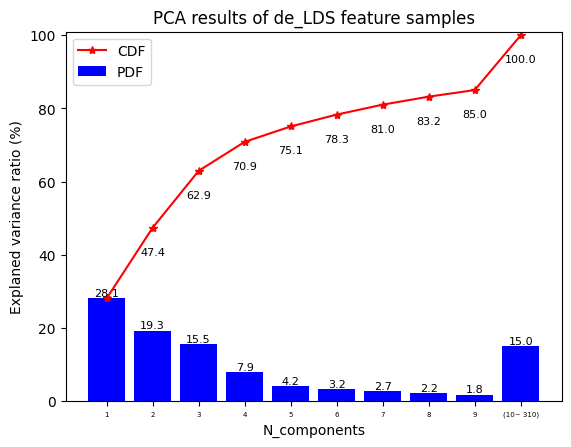

In [53]:
best_acc_list = []
orig_acc_list = []

compare_args.gcn_hid_channels = 9
compare_args.gcn_out_channels = 18
for i in range(15):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
    psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

    de_pca,_ = dimensionality_reduction(de, compare_args.pca_components1, 'de_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de_pca)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    
    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)
    label = sub_label
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    label = torch.from_numpy(label).to(torch.long).to(device)

    feature = de_pca

    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(de_ssm).to(torch.float32).to(device)
    adj = normalize_adj(adj, im)

    model = compare_model(compare_args,compare_args.pca_components1,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)

    best_acc, graph = train(feature, label, train_identifier, test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_DE_PCA_GCN_protocol_'+str(n_labels_by_trials*args.n_subjects)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity=50, n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PCA_GCN', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    best_acc_list.append(best_acc)
    orig_acc_list.append(best_acc)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list,np.mean(orig_acc_list), np.std(orig_acc_list)))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+'ablation2/', 'DE_PCA_GCN_protocol_'+str(n_labels_by_trials*args.n_subjects)+'_best_acc_list_'+date, best_acc_list)


## PSD + PCA + GCN



******************* SUBJECT : 1 *********************
Explaned variance ratio by principal components : [0.26022069 0.18783203 0.12818577 0.07686963 0.0578009  0.05101084] 
 Overall ratio:  0.7619198601590595

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 40.56    Train Loss : 1.06,    Test Acc : 42.39    Test Loss : 1.06
Epoch 20 - Train Acc : 45.0    Train Loss : 0.99,    Test Acc : 43.47    Test Loss : 1.0
Epoch 30 - Train Acc : 50.56    Train Loss : 0.95,    Test Acc : 48.19    Test Loss : 0.98
Epoch 40 - Train Acc : 51.11    Train Loss : 0.93,    Test Acc : 49.58    Test Loss : 0.96
Epoch 50 - Train Acc : 50.0    Train Loss : 0.91,    Test Acc : 50.39    Test Loss : 0.94
Epoch 60 - Train Acc : 49.44    Train Loss : 0.9,    Test Acc : 50.53    Test Loss : 0.93
Epoch 70 - Train Acc : 50.0    Train Loss : 0.89,   

Epoch 170 - Train Acc : 83.33    Train Loss : 0.41,    Test Acc : 78.36    Test Loss : 0.51
Epoch 180 - Train Acc : 83.33    Train Loss : 0.39,    Test Acc : 78.4    Test Loss : 0.5
Epoch 190 - Train Acc : 82.78    Train Loss : 0.37,    Test Acc : 79.02    Test Loss : 0.48
Epoch 200 - Train Acc : 83.89    Train Loss : 0.35,    Test Acc : 79.62    Test Loss : 0.47
directory already exists
scatter_PSD_PCA_GCN is saved successfully
*** Best ACC : 79.62 ***


******************* SUBJECT : 5 *********************
Explaned variance ratio by principal components : [0.33353989 0.14458415 0.09628843 0.07995492 0.04921963 0.04644021] 
 Overall ratio:  0.750027216809151

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 62.22    Train Loss : 0.96,    Test Acc : 66.6    Test Loss : 0.95
Epoch 20 - Train Acc : 65.56    Train Loss : 0.

Epoch 90 - Train Acc : 90.0    Train Loss : 0.28,    Test Acc : 91.37    Test Loss : 0.27
Epoch 100 - Train Acc : 90.56    Train Loss : 0.26,    Test Acc : 91.61    Test Loss : 0.25
Epoch 110 - Train Acc : 91.11    Train Loss : 0.24,    Test Acc : 91.98    Test Loss : 0.23
Epoch 120 - Train Acc : 91.67    Train Loss : 0.21,    Test Acc : 92.65    Test Loss : 0.21
Epoch 130 - Train Acc : 92.78    Train Loss : 0.19,    Test Acc : 93.5    Test Loss : 0.18
Epoch 140 - Train Acc : 93.33    Train Loss : 0.17,    Test Acc : 93.96    Test Loss : 0.16
Epoch 150 - Train Acc : 95.0    Train Loss : 0.15,    Test Acc : 95.03    Test Loss : 0.15
Epoch 160 - Train Acc : 96.11    Train Loss : 0.13,    Test Acc : 95.76    Test Loss : 0.13
Epoch 170 - Train Acc : 96.67    Train Loss : 0.12,    Test Acc : 96.57    Test Loss : 0.13
Epoch 180 - Train Acc : 96.67    Train Loss : 0.11,    Test Acc : 97.15    Test Loss : 0.12
Epoch 190 - Train Acc : 96.67    Train Loss : 0.1,    Test Acc : 97.33    Test Loss 


Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 35.0    Train Loss : 1.03,    Test Acc : 36.54    Test Loss : 1.03
Epoch 20 - Train Acc : 55.0    Train Loss : 0.92,    Test Acc : 53.27    Test Loss : 0.93
Epoch 30 - Train Acc : 62.22    Train Loss : 0.84,    Test Acc : 58.26    Test Loss : 0.85
Epoch 40 - Train Acc : 66.11    Train Loss : 0.76,    Test Acc : 62.56    Test Loss : 0.79
Epoch 50 - Train Acc : 70.56    Train Loss : 0.72,    Test Acc : 64.89    Test Loss : 0.75
Epoch 60 - Train Acc : 70.0    Train Loss : 0.69,    Test Acc : 66.15    Test Loss : 0.74
Epoch 70 - Train Acc : 71.11    Train Loss : 0.68,    Test Acc : 67.46    Test Loss : 0.73
Epoch 80 - Train Acc : 71.67    Train Loss : 0.66,    Test Acc : 68.48    Test Loss : 0.72
Epoch 90 - Train Acc : 73.33    Train Loss : 0.64,    Test Acc : 69.71    Test L

Epoch 170 - Train Acc : 97.22    Train Loss : 0.08,    Test Acc : 98.04    Test Loss : 0.06
Epoch 180 - Train Acc : 97.22    Train Loss : 0.08,    Test Acc : 98.1    Test Loss : 0.06
Epoch 190 - Train Acc : 97.22    Train Loss : 0.07,    Test Acc : 98.15    Test Loss : 0.06
Epoch 200 - Train Acc : 97.22    Train Loss : 0.07,    Test Acc : 98.21    Test Loss : 0.06
directory already exists
scatter_PSD_PCA_GCN is saved successfully
*** Best ACC : 98.21 ***

**************** Best acc by subject *********************
** Best ACC : [83.21, 76.25, 82.82, 79.62, 82.05, 73.43, 85.23, 97.55, 82.82, 68.24, 93.14, 84.19, 81.77, 83.66, 98.21] **
 ** Avearge acc : 83.47933333333334,    std : 7.823886899886924 **

directory already exists
protocol 60_best_acc_list_231016 is saved successfully


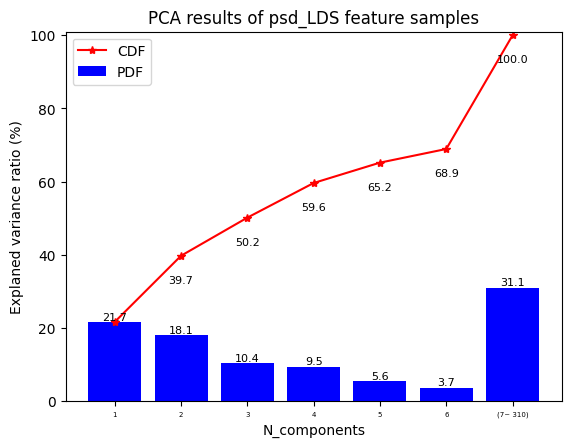

In [54]:
best_acc_list = []
orig_acc_list = []

compare_args.gcn_hid_channels = 6
compare_args.gcn_out_channels = 12
for i in range(15):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
    psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

    psd_pca,_ = dimensionality_reduction(psd, compare_args.pca_components2, 'psd_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    psd_dm = distance_matrix(psd_pca)
    print("\nDistance matrix construction Done...")

    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)
    label = sub_label
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    label = torch.from_numpy(label).to(torch.long).to(device)
    
    feature = psd_pca

    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(psd_ssm).to(torch.float32).to(device)
    adj = normalize_adj(adj,im)

    model = compare_model(compare_args,compare_args.pca_components2,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)

    best_acc, graph = train(feature, label, train_identifier, test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_PSD_PCA_GCN_protocol_'+str(n_labels_by_trials*args.n_subjects)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'PSD_PCA_GCN', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    best_acc_list.append(best_acc)
    orig_acc_list.append(best_acc)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list,np.mean(orig_acc_list), np.std(orig_acc_list)))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+'ablation2/', 'PSD_PCA_GCN_protocol_'+str(n_labels_by_trials*args.n_subjects)+'_best_acc_list_'+date, best_acc_list)

## DE+PSD+PCA+SNF+GCN



******************* SUBJECT : 1 *********************
Explaned variance ratio by principal components : [0.30128435 0.24427401 0.15043273 0.07453851 0.04433173 0.03662695
 0.02023481 0.01259767 0.00985163] 
 Overall ratio:  0.8941723945927312

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.26022069 0.18783203 0.12818577 0.07686963 0.0578009  0.05101084] 
 Overall ratio:  0.7619198601590339

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :

Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.46    Test Loss : 0.09
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.46    Test Loss : 0.09
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.46    Test Loss : 0.09
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.47    Test Loss : 0.1
directory already exists
scatter_DE_PSD_PCA_SNF_GCN is saved successfully
*** Best ACC : 98.47 ***


******************* SUBJECT : 4 *********************
Explaned variance ratio by principal components : [0.24253363 0.20840128 0.16311952 0.08271843 0.07398657 0.03812235
 0.02142844 0.01533521 0.01472575] 
 Overall ratio:  0.8603711922479378

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.40343803 0.13302112 0.11474737 0.07961511 0.0

Epoch 90 - Train Acc : 99.44    Train Loss : 0.06,    Test Acc : 96.48    Test Loss : 0.14
Epoch 100 - Train Acc : 100.0    Train Loss : 0.04,    Test Acc : 97.53    Test Loss : 0.11
Epoch 110 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 97.71    Test Loss : 0.11
Epoch 120 - Train Acc : 100.0    Train Loss : 0.02,    Test Acc : 97.73    Test Loss : 0.1
Epoch 130 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.82    Test Loss : 0.1
Epoch 140 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.88    Test Loss : 0.1
Epoch 150 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.89    Test Loss : 0.1
Epoch 160 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.91    Test Loss : 0.1
Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.94    Test Loss : 0.1
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.94    Test Loss : 0.1
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.96    Test Loss : 0.1
E

Epoch 10 - Train Acc : 78.89    Train Loss : 0.76,    Test Acc : 80.14    Test Loss : 0.77
Epoch 20 - Train Acc : 87.22    Train Loss : 0.41,    Test Acc : 84.67    Test Loss : 0.4
Epoch 30 - Train Acc : 92.78    Train Loss : 0.22,    Test Acc : 89.89    Test Loss : 0.23
Epoch 40 - Train Acc : 94.44    Train Loss : 0.15,    Test Acc : 91.8    Test Loss : 0.17
Epoch 50 - Train Acc : 95.0    Train Loss : 0.12,    Test Acc : 93.89    Test Loss : 0.14
Epoch 60 - Train Acc : 95.56    Train Loss : 0.09,    Test Acc : 94.97    Test Loss : 0.13
Epoch 70 - Train Acc : 97.22    Train Loss : 0.07,    Test Acc : 96.09    Test Loss : 0.12
Epoch 80 - Train Acc : 98.89    Train Loss : 0.06,    Test Acc : 95.75    Test Loss : 0.12
Epoch 90 - Train Acc : 98.89    Train Loss : 0.04,    Test Acc : 96.18    Test Loss : 0.12
Epoch 100 - Train Acc : 99.44    Train Loss : 0.03,    Test Acc : 96.54    Test Loss : 0.12
Epoch 110 - Train Acc : 99.44    Train Loss : 0.02,    Test Acc : 96.85    Test Loss : 0.12



********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.48998157 0.19254017 0.09782136 0.04666136 0.04107608 0.02548056] 
 Overall ratio:  0.893561105810276

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.5380 sec
Done
**********************************************
Epoch 10 - Train Acc : 78.33    Train Loss : 0.85,    Test Acc : 77.78    Test Loss : 0.85
Epoch 20 - Train Acc : 86.67    Train Loss : 0.48,    Test Acc : 85.71    Test Loss : 0.5
Epoch 30 - Train Acc : 93.33    Train Loss : 0.23,    Test Acc : 94.3    T


Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Explaned variance ratio by principal components : [0.21667168 0.1808224  0.10417631 0.09467664 0.05561769 0.03732109] 
 Overall ratio:  0.6892858112379429

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
10.6351 sec
Done
**********************************************
Epoch 10 - Train Acc : 89.44    Train Loss : 0.64,    Test Acc : 92.3    Test Loss : 0.64
Epoch 20 - Train Acc : 97.22    Train Loss : 0.2,    Test Acc : 98.59    Test Loss : 0.

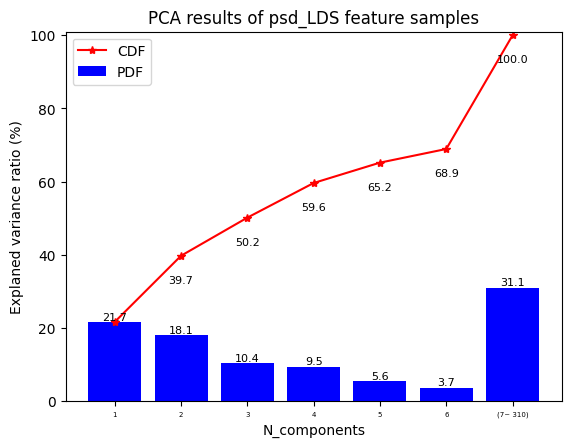

In [57]:
best_acc_list = []
orig_acc_list = []

compare_args.gcn_hid_channels = 15
compare_args.gcn_out_channels = 30
for i in range(15):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
    psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

    de_pca,_ = dimensionality_reduction(de, compare_args.pca_components1, 'de_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de_pca)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    
    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)
    label = sub_label
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)
    
    psd_pca,_ = dimensionality_reduction(psd, compare_args.pca_components2, 'psd_LDS', sub_idx, date)
    
    print("\nDistance matrix construction start...")
    psd_dm = distance_matrix(psd_pca)
    print("\nDistance matrix construction Done...")

    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
    adj = fsm


    feature = input_feature(de_pca, psd_pca)
    label = torch.from_numpy(label).to(torch.long).to(device)
    
 
    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(fsm).to(torch.float32).to(device)
    adj = normalize_adj(adj,im)
    
    model = compare_model(compare_args,compare_args.pca_components1+compare_args.pca_components2,adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)

    best_acc, graph = train(feature, label, train_identifier, test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_DE_PSD_PCA_SNF_GCN_protocol_'+str(n_labels_by_trials*args.n_subjects)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PSD_PCA_SNF_GCN', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    best_acc_list.append(best_acc)
    orig_acc_list.append(best_acc)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list,np.mean(orig_acc_list), np.std(orig_acc_list)))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+'ablation2/', 'DE_PSD_PCA_SNF_GCN_protocol_'+str(n_labels_by_trials*args.n_subjects)+'_best_acc_list_'+date, best_acc_list)

## DE+GE

In [58]:
best_acc_list = []
orig_acc_list = []

for i in range(15):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
    psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        
    de = normalization(de, axis = 0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    
    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)
    label = sub_label
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    label = torch.from_numpy(label).to(torch.long).to(device)

    feature = de

    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(de_ssm).to(torch.float32).to(device)
    adj = normalize_adj(adj, im)

        
    encoder = Encoder(args.feature_dimension//2,args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, label, train_identifier, test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_DE_GE_protocol_'+str(n_labels_by_trials*args.n_subjects)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    best_acc_list.append(best_acc)
    orig_acc_list.append(best_acc)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list,np.mean(orig_acc_list), np.std(orig_acc_list)))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+'ablation2/', 'DE_GE_protocol_'+str(n_labels_by_trials*args.n_subjects)+'_best_acc_list_'+date, best_acc_list)




******************* SUBJECT : 1 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 98.89    Train Loss : 0.04,    Test Acc : 97.49    Test Loss : 0.07
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.74    Test Loss : 0.08
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.25    Test Loss : 0.19
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.09    Test Loss : 0.2
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.9    Test Loss : 0.2
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.97    Test Loss : 0.2
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.99    Test Loss : 0.19
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.19    Test Loss : 0.19
Epoch 90 - Train Acc : 100.0    


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 99.44    Train Loss : 0.02,    Test Acc : 97.07    Test Loss : 0.13
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.67    Test Loss : 0.09
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.34    Test Loss : 0.09
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.64    Test Loss : 0.1
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.65    Test Loss : 0.1
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.65    Test Loss : 0.1
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.72    Test Loss : 0.1
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.75    Test Loss : 0.1
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.77    Test Loss : 0.1
Epoch 100 - Train Acc : 100.0    Train 


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.4    Test Loss : 0.07
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.74    Test Loss : 0.16
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.91    Test Loss : 0.17
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.09    Test Loss : 0.16
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.33    Test Loss : 0.16
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.4    Test Loss : 0.16
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.42    Test Loss : 0.16
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.44    Test Loss : 0.16
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.44    Test Loss : 0.16
Epoch 100 - Train Acc : 100.0    Tr


Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 98.77    Test Loss : 0.03
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.83    Test Loss : 0.07
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.78    Test Loss : 0.14
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.98    Test Loss : 0.16
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.21    Test Loss : 0.17
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.2    Test Loss : 0.17
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.21    Test Loss : 0.17
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.21    Test Loss : 0.17
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.21    Test Loss : 0.17
Epoch 100 - Train Acc : 100.0    T

# PSD+GE

In [59]:
best_acc_list = []
orig_acc_list = []

for i in range(15):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
    psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        
    psd = normalization(psd, axis = 0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    psd_dm = distance_matrix(psd)
    print("\nDistance matrix construction Done...")

    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)
    label = sub_label
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    label = torch.from_numpy(label).to(torch.long).to(device)

    feature = psd

    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(psd_ssm).to(torch.float32).to(device)
    adj = normalize_adj(adj, im)
    
    encoder = Encoder(args.feature_dimension//2,args.gcn_hid_channels//2, args.gcn_out_channels//2, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension//2, args.gcn_out_channels//2, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, label, train_identifier, test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_PSD_GE_protocol_'+str(n_labels_by_trials*args.n_subjects)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'PSD_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    best_acc_list.append(best_acc)
    orig_acc_list.append(best_acc)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list,np.mean(orig_acc_list), np.std(orig_acc_list)))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+'ablation2/', 'PSD_GE_protocol_'+str(n_labels_by_trials*args.n_subjects)+'_best_acc_list_'+date, best_acc_list)




******************* SUBJECT : 1 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 98.89    Train Loss : 0.04,    Test Acc : 98.0    Test Loss : 0.07
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.62    Test Loss : 0.1
Epoch 30 - Train Acc : 98.33    Train Loss : 0.04,    Test Acc : 96.99    Test Loss : 0.17
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.75    Test Loss : 0.15
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.75    Test Loss : 0.16
Epoch 60 - Train Acc : 97.78    Train Loss : 0.36,    Test Acc : 98.89    Test Loss : 0.13
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.99    Test Loss : 0.35
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.52    Test Loss : 0.71
Epoch 90 - Train Acc : 100.0

directory already exists
scatter_PSD_GE is saved successfully
*** Best ACC : 96.82 ***


******************* SUBJECT : 5 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 99.44    Train Loss : 0.01,    Test Acc : 97.28    Test Loss : 0.14
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.51    Test Loss : 0.26
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.66    Test Loss : 0.35
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.67    Test Loss : 0.39
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.67    Test Loss : 0.4
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.67    Test Loss : 0.41
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.67    Test Loss : 0.41
Epoch 80 - Train Acc : 100.0    

Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.64    Test Loss : 0.15
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.63    Test Loss : 0.15
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.63    Test Loss : 0.15
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.63    Test Loss : 0.15
directory already exists
scatter_PSD_GE is saved successfully
*** Best ACC : 98.63 ***


******************* SUBJECT : 9 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 96.67    Train Loss : 0.09,    Test Acc : 95.25    Test Loss : 0.15
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.59    Test Loss : 0.09
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.66    Test Loss : 0.15
Epoch 40 - Train Acc : 100.

Epoch 150 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.14    Test Loss : 0.18
Epoch 160 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.14    Test Loss : 0.18
Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.15    Test Loss : 0.19
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.15    Test Loss : 0.19
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.15    Test Loss : 0.19
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.16    Test Loss : 0.19
directory already exists
scatter_PSD_GE is saved successfully
*** Best ACC : 98.16 ***


******************* SUBJECT : 13 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done

Epoch 10 - Train Acc : 100.0    Train Loss : 0.01,    Test Acc : 97.19    Test Loss : 0.06
Epoch 20 - Train Acc : 1

# DE+PSD+SNF+GE

In [60]:
best_acc_list = []
orig_acc_list = []

for i in range(15):

    print("\n\n******************* SUBJECT : {} *********************".format(i+1))
    sub_idx = 'sub'+str(i+1)
    date = '231016'

    sub_de = subject_de[i]
    sub_psd = subject_psd[i]
    sub_label = subject_label[i]
    sub_sample_counts = subject_sample_counts[i]

    de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
    psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        
    de = normalization(de, axis = 0, ntype='standardization')
    psd = normalization(psd, axis=0, ntype='standardization')
    
    print("\nDistance matrix construction start...")
    de_dm = distance_matrix(de)
    psd_dm = distance_matrix(psd)
    print("\nDistance matrix construction Done...")

    de_neighbors = kneighbors(de_dm, args.n_samples, args.de_k)
    psd_neighbors = kneighbors(psd_dm, args.n_samples, args.psd_k)

    de_ssm, de_nssm = ssm_construction(de_dm,de_neighbors)
    psd_ssm, psd_nssm = ssm_construction(psd_dm,psd_neighbors)
    
    fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
    
    identifier = torch.from_numpy(identifier).bool()
    train_identifier = identifier.to(device)
    isunlabeled = ~identifier

    test_identifier = isunlabeled.to(device)
    label = sub_label
#     save_np(args.tensor_save_path+sub_idx, 'identifier', identifier)
#     save_np(args.tensor_save_path+sub_idx, 'label', label)

    label = torch.from_numpy(label).to(torch.long).to(device)

    feature = input_feature(de,psd)

    feature = torch.from_numpy(feature).to(torch.float32).to(device)
    adj = torch.from_numpy(fsm).to(torch.float32).to(device)
    adj = normalize_adj(adj, im)

    
    encoder = Encoder(args.feature_dimension,args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
    model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = compare_args.learning_rate)
    best_acc, graph = encoder_train(feature,adj, label, train_identifier, test_identifier, model, optimizer, compare_args.epochs)

    experiment_type = 'subject_dependent'
    model_save_name = sub_idx+'_ablation3_DE_PSD_SNF_GE_protocol_'+str(n_labels_by_trials*args.n_subjects)
    model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
    torch.save(model.state_dict(), model_path)

    sample = graph.cpu().detach().numpy().copy()
#     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
#     tsne_sample = StandardScaler().fit_transform(sample) # standardization
#     dr_result = drmodel.fit_transform(tsne_sample)
#     save_scatter(dr_result, label, best_acc,sub_idx, date, args.figure_save_path, visualization_type, train_identifier)
    
    save_np(args.tensor_save_path+'/ablation3/'+sub_idx,'DE_PSD_SNF_GE', sample)
    
    print("*** Best ACC : {} ***".format(best_acc))
    best_acc_list.append(best_acc)
    orig_acc_list.append(best_acc)

print("\n**************** Best acc by subject *********************")
print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list,np.mean(orig_acc_list), np.std(orig_acc_list)))
best_acc_list = np.array(best_acc_list)
save_np(args.tensor_save_path+'ablation2/', 'DE_PSD_SNF_GE_protocol_'+str(n_labels_by_trials*args.n_subjects)+'_best_acc_list_'+date, best_acc_list)




******************* SUBJECT : 1 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
11.8165 sec
Done
**********************************************
Epoch 10 - Train Acc : 93.89    Train Loss : 0.11,    Test Acc : 92.81    Test Loss : 0.21
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.13    Test Loss : 0.12
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.52    Test Loss : 0.22
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.86    Test Loss

14.8528 sec
Done
**********************************************
Epoch 10 - Train Acc : 96.11    Train Loss : 0.07,    Test Acc : 91.02    Test Loss : 0.35
Epoch 20 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 96.11    Test Loss : 0.41
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 96.87    Test Loss : 0.42
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.21    Test Loss : 0.44
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.31    Test Loss : 0.45
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.36    Test Loss : 0.46
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.39    Test Loss : 0.46
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.43    Test Loss : 0.46
Epoch 90 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.45    Test Loss : 0.46
Epoch 100 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 97.48    Test Loss : 0.46
Epoch 110 - Train Acc : 100.0    T

Epoch 110 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.77    Test Loss : 0.14
Epoch 120 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.79    Test Loss : 0.14
Epoch 130 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.79    Test Loss : 0.14
Epoch 140 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.79    Test Loss : 0.14
Epoch 150 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.79    Test Loss : 0.13
Epoch 160 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.79    Test Loss : 0.13
Epoch 170 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.8    Test Loss : 0.13
Epoch 180 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.8    Test Loss : 0.13
Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.8    Test Loss : 0.13
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 98.81    Test Loss : 0.13
directory already exists
scatter_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 98.81 ***

Epoch 190 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 96.45    Test Loss : 0.77
Epoch 200 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 96.46    Test Loss : 0.77
directory already exists
scatter_DE_PSD_SNF_GE is saved successfully
*** Best ACC : 96.46 ***


******************* SUBJECT : 11 *********************

Distance matrix construction start...

Distance matrix construction Done...

********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
13.0328 sec
Done
**********************************************
Epoch 10 - Train Acc : 99.44    Train Loss : 0.03,    Test Acc : 96.22    Te

Done


********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
13.2542 sec
Done
**********************************************
Epoch 10 - Train Acc : 97.22    Train Loss : 0.17,    Test Acc : 92.27    Test Loss : 0.39
Epoch 20 - Train Acc : 98.89    Train Loss : 0.02,    Test Acc : 95.18    Test Loss : 0.18
Epoch 30 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 95.89    Test Loss : 0.25
Epoch 40 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 95.32    Test Loss : 0.38
Epoch 50 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 95.35    Test Loss : 0.43
Epoch 60 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 95.85    Test Loss : 0.43
Epoch 70 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 95.88    Test Loss : 0.42
Epoch 80 - Train Acc : 100.0    Train Loss : 0.0,    Test Acc : 95.93    Test Loss :

In [27]:
best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, label,
                                                                                    train_identifier, test_identifier,
                                                                                    args,device,date,sub_idx, isdeap=False, verbose=True)


Epoch 100 - Train Acc : 99.58    Train Loss : 0.11,    Test Acc : 98.82,    Test Loss :0.07,    Total Acc : 99.2
Epoch 200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.37,    Test Loss :0.12,    Total Acc : 99.68
Epoch 300 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.62,    Test Loss :0.11,    Total Acc : 99.81
Epoch 400 - Train Acc : 99.86    Train Loss : 0.1,    Test Acc : 99.66,    Test Loss :0.03,    Total Acc : 99.76
Epoch 500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.46,    Test Loss :0.04,    Total Acc : 99.73
Epoch 600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.21,    Test Loss :0.12,    Total Acc : 99.6
Epoch 700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.65,    Test Loss :0.09,    Total Acc : 99.83
Epoch 800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.68,    Test Loss :0.05,    Total Acc : 99.84
Epoch 900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.45,    Test Loss :0.05,    To

KeyboardInterrupt: 

# Edge drop hyperparameter validation

In [273]:
drop_features(feature, adj, 0.1)

tensor([0.9799, 0.9831, 0.9841, 0.9768, 0.9771, 0.9678, 0.9316, 0.9309, 0.8962,
        0.9055, 0.9393, 0.9465, 0.9641, 0.9234, 0.9590, 0.9240, 0.9305, 0.9317,
        0.9401, 0.9515, 0.9146, 0.9384, 0.9289, 0.9477, 0.9246, 0.9270, 0.9475,
        0.9976, 0.9988, 0.9267, 0.9059, 0.9225, 0.9338, 0.9253, 0.9638, 0.9094,
        0.9854, 0.9458, 0.9430, 0.9387, 0.9164, 0.9092, 0.9189, 0.9381, 0.9749,
        0.9880, 0.9062, 0.9382, 0.9212, 0.9268, 0.9095, 0.9084, 0.8920, 0.8948,
        0.8015, 0.9425, 0.9427, 0.9326, 0.9401, 0.9608, 0.9495, 0.9430, 0.9884,
        0.9848, 0.9785, 0.9740, 0.9787, 0.9720, 0.9536, 0.9524, 0.9413, 0.9656,
        0.8708, 0.8938, 0.9526, 0.9325, 0.9652, 0.9113, 0.9163, 0.9148, 0.9691,
        0.9783, 0.9197, 0.9212, 0.8937, 0.9526, 0.9406, 0.9471, 0.9419, 0.9970,
        1.0000, 0.9359, 0.9276, 0.9060, 0.9805, 0.9285, 0.9575, 0.9126, 0.9775,
        0.9644, 0.9618, 0.9385, 0.9209, 0.9199, 0.9463, 0.9716, 0.9474, 0.9438,
        0.9317, 0.9781, 0.9592, 0.9558, 

tensor([[-0.9299, -0.9922, -1.3947,  ..., -0.1198,  0.6016,  0.5215],
        [-0.9305, -0.9918, -1.3938,  ..., -0.1196,  0.6023,  0.5221],
        [-0.9314, -0.9922, -1.3941,  ..., -0.1192,  0.6038,  0.5234],
        ...,
        [-1.7059, -1.4937, -1.3851,  ...,  0.7166,  1.0864,  1.0704],
        [-1.7075, -1.4946, -1.3852,  ...,  0.7163,  1.0861,  1.0702],
        [-1.7081, -1.4952, -1.3858,  ...,  0.7161,  1.0858,  1.0699]],
       device='cuda:1')

In [263]:

def drop_edges(edge_weights, p: float, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights)
    weight_max = edge_weights.max()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())

    probability_weights = weights / weights.mean() * p
    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))
    
    return edge_weights_view

# Feature drop hyperparameter validation

In [270]:
def drop_features(features, edges, p: float, threshold: float = 0.7):
    x = torch.abs(features)
    row_sum = torch.sum(edges, axis=0)
    feature_weights = x.t() @ row_sum
    feature_weights = feature_weights.log()
    weight_max = feature_weights.max()
    w = (weight_max-feature_weights)/(weight_max-feature_weights.mean())

    probability_weights = w / w.mean() * p
    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view


In [12]:
def drop_features2(probability_weights, features, threshold: float = 1.):

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold) 
    drop_mask = torch.bernoulli(probability_weights).to(torch.bool)
    
    features_view = features.clone()
    features_view[:,drop_mask] = 0.

    return features_view

def edge_rank(edge_weights):
    weight_max = edge_weights.max()
    weight_mean = edge_weights.mean()
    weights = (weight_max-edge_weights)/(weight_max-edge_weights.mean())
    return weights

def drop_edges2(probability_weights, edge_weights, threshold: float = 1.):
#     alleviated_weights = torch.log(edge_weights

    probability_weights = probability_weights.where(probability_weights < threshold, torch.ones_like(probability_weights) * threshold)
    drop_mask = torch.bernoulli(1. - probability_weights).to(torch.bool)
   
    edge_weights_view = edge_weights.where(drop_mask == True, torch.zeros_like(edge_weights))

    return edge_weights_view


def GCA_train2(model, otimizer, feature, orig_adj, label, train_identifier, test_identifier, args, device,date = None,sub_idx = None, isdeap=False ):
#     save_path = args.model_save_path+'subject_dependent/'+date+'/'+sub_idx+'.pt'
#     early_stopping = EarlyStopping(patience = args.patience, verbose = False, path=save_path)
    best_acc = 0
    best_epoch = 0
    best_model = None
    best_z = None
#     w = 0.5

    rankf = disc_rank(feature, label,train_identifier, args.out_channels)
    rankf1 = rankf*args.pf1
    rankf2 = rankf*args.pf2
    ranke = edge_rank(adj)
    ranke1 = ranke*args.pe1
    ranke2 = ranke*args.pe2
    
    for epoch in range(1, args.epochs+1):
        model.train()
        optimizer.zero_grad()
        x1 = drop_features2(rankf1, feature, threshold = args.tpf1)
        x2 = drop_features2(rankf2, feature, threshold = args.tpf2)
        e1 = drop_edges2(ranke1,orig_adj, threshold = args.tpe1)
        e2 = drop_edges2(ranke2,orig_adj, threshold = args.tpe2)

#         x1 = drop_features(feature, adj, p = 0.1, threshold = args.tpf1)
#         x2 = drop_features(feature, adj, p = 0.2, threshold = args.tpf2)
#         e1 = drop_edges(adj, p = 0.1, threshold = args.tpe1)
#         e2 = drop_edges(adj, p = 0.2, threshold = args.tpe2)
        
        z1 = model(x1,e1) #,bias = True)
#         z1 = model(feature,adj)
        z1 = model.projection(z1)
        z2 = model(x2,e2)
        z2 = model.projection(z2)   
        
#         ne1 = model.decoder(z1)
#         ne2 = model.decoder(z2)
 
#         ne1 = (ne1-ne1.min())/(ne1.max()-ne1.min())
#         ne2 = (ne2-ne2.min())/(ne2.max()-ne2.min())
#         nadj1 = w*adj + (1.-w)*ne1
#         nadj2 = w*adj + (1.-w)*ne2
#         nadj = 0.5*(nadj1+nadj2)
#         print(nadj)
 
        r1 = model.classification(z1)
        r1_pred = r1[train_identifier]
        r1_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss1 = criterion(r1_pred, r1_y)
        r1_acc = accuracy(r1_pred, r1_y, isdeap)

        r2 = model.classification(z2)
        r2_pred = r2[train_identifier]
        r2_y = label[train_identifier]
        # L2 regularization is not implemented yet
        labeled_loss2 = criterion(r2_pred, r2_y)
        r2_acc = accuracy(r2_pred, r2_y, isdeap)

        
        contrastive_loss = model.loss(z1,z2)
#         print(contrastive_loss)
        loss = (labeled_loss1 + labeled_loss2)/2. + contrastive_loss*args.loss_lambda
#         loss = labeled_loss1 + contrastive_loss*args.loss_lambda

        loss.backward()
        optimizer.step()
        
#         orig_adj = nadj.detach().clone().to(device)
#         print(orig_adj)
#         adj = nadj.detach().clone().cuda()
        acc = (r1_acc + r2_acc)/2.
#         acc = r1_acc
        
        tr1_pred = r1[test_identifier]
        tr1_y = label[test_identifier]
        tr1_loss = criterion(tr1_pred, tr1_y)
        tr1_acc = accuracy(tr1_pred, tr1_y, isdeap)
        
        tr2_pred = r2[test_identifier]
        tr2_y = label[test_identifier]
        tr2_acc = accuracy(tr2_pred, tr2_y, isdeap)
        tr2_loss = criterion(tr2_pred, tr2_y)
        
#         tr_acc = (tr1_acc + tr2_acc)/2.
        if tr1_acc > tr2_acc:
            result = r1
            tr_acc = tr1_acc
        else:
            result = r2
            tr_acc = tr2_acc
        
        tr_loss = (tr1_loss + tr2_loss)/2.
        total_acc = (tr_acc + acc)/2.
        
        if tr_acc > best_acc :
            best_acc = tr_acc
            best_epoch = epoch
            best_model = model
            
            best_result = result
            best_z = z1 if tr1_acc > tr2_acc else z2


#         if epoch % 10 == 0:
#             print("Epoch {} - Train Acc : {}    Train Loss : {},    Test Acc : {},    Test Loss :{},    Total Acc : {}".format(epoch, round(acc.item(), 2), round(loss.item(),2), round(tr_acc.item(),2), round(tr_loss.item(),2), round(total_acc.item(), 2)))

#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             print('Epoch : {} - Ealry Stopping'.format(epoch))
#             break
#     model.load_state_dict(torch.load(save_path))
    return model, best_acc, best_epoch, best_model, best_z, best_result


# GCAtrain2 + = pe, pf ablation
# Row max, mean without Self-similarity 

# Label 60

In [ ]:
for e in range(9):
    for f in range(9):
        print("\n****** Pe: {}, Pf: {}*****".format((e+1)/10, (f+1)/10))
        print("Acc : {}, Std : {}".format(Best_EF_acc[e][f],Best_EF_std[e][f]))
        

Device: cuda
Current cuda device: 2
Count of using GPUs: 3
========================================== SEED Protocol 120 ==========================================


******************* SUBJECT : 13 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
15.8

Epoch 2400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.01,    Total Acc : 100.0
Epoch 2700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 3000 - Train Acc : 99.72    Train Loss : 0.1,    Test Acc : 99.93,    Test Loss :0.01,    Total Acc : 99.83
*** Best ACC : 100.0 ***


******************* SUBJECT : 15 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse 

/tmp/ipykernel_23274/4212163399.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(matrix)


Epoch 100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 300 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 500 - Train Acc : 99.72    Train Loss : 0.12,    Test Acc : 99.66,    Test Loss :0.09,    Total Acc : 99.69
Epoch 600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.02,    Total Acc : 100.0
Epoch 900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total A

<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

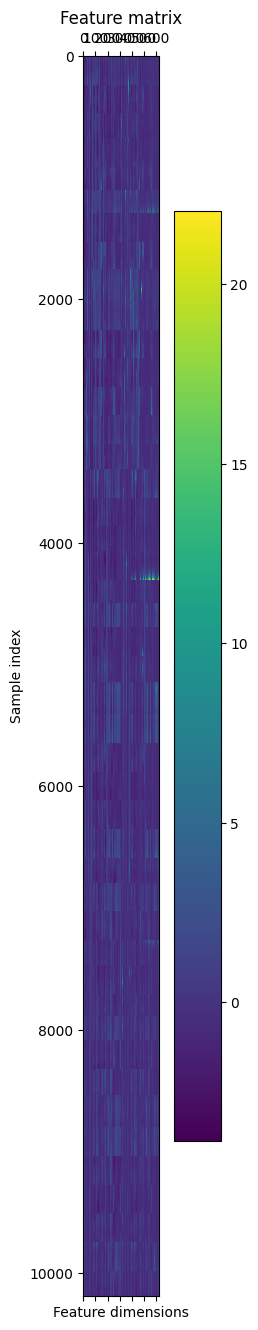

In [20]:
# GCAtrain2 + = pe, pf ablation
# Row max, mean without Self-similarity cp.cuda.Device(0).use()

args = get_seed_args()

device = get_device(args.bus_id, args.cuda_id[2])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)

visualization_type = 1

args.tpe1 = 1.
args.tpe2 = 1.
args.tpf1 = 1.
args.tpf2 = 1.

for p in range(1):
    if p == 0:
        n_labels_by_trials = args.n_labels_by_trials3
    elif p == 1:
        n_labels_by_trials = args.n_labels_by_trials2
    else:
        n_labels_by_trials = args.n_labels_by_trials1

    best_epoch_list = []
    best_acc_list = []
    orig_acc_list = []

    print("========================================== SEED Protocol {} ==========================================".format(int(n_labels_by_trials*15)))

    for i in range(12,15):
        print("\n\n******************* SUBJECT : {} *********************".format(i+1))
        sub_idx = 'sub'+str(i+1)
        date = '230522'

        sub_de = subject_de[i]
        sub_psd = subject_psd[i]
        sub_label = subject_label[i]
        sub_sample_counts = subject_sample_counts[i]

        de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
        psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        de = normalization(de, axis = 0, ntype='standardization')
        psd = normalization(psd, axis = 0, ntype='standardization')

        de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
        psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

        save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
        save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
        save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
        save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
        save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        adj = normalize_adj(fsm)
        save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
        save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        feature = input_feature(de, psd)
        label = sub_label

        save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

        feature = torch.from_numpy(feature).to(torch.float32).to(device)
        adj = torch.from_numpy(adj).to(torch.float32).to(device)
        label = torch.from_numpy(label).to(torch.long).to(device)

        identifier = torch.from_numpy(identifier).bool()
        train_identifier = identifier.to(device)
        isunlabeled = ~identifier

        test_identifier = isunlabeled.to(device)

        activation = get_activation('celu')
        gcn = GraphConvolution

        encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
        model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

        best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, label,
                                                                            train_identifier, test_identifier,
                                                                            args,device,date,sub_idx, isdeap=False)

        experiment_type = 'subject_dependent'
        model_save_name = sub_idx+'_model'
        model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
        torch.save(model.state_dict(), model_path)

        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        best_epoch_list.append(best_epoch)
        best_acc_list.append(round(best_acc.item(), 2))
        orig_acc_list.append(best_acc.item())


    #     sample = best_z.cpu().detach().numpy().copy()
    #     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
    #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
    #     dr_result = drmodel.fit_transform(tsne_sample)

    #     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

    print("\n**************** Best acc by subject *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))


    print("\n Best Epochs : {}".format(best_epoch_list))
    best_acc_list = np.array(best_acc_list)
    save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_trials)+'_best_acc_list_'+date, best_acc_list)


Device: cuda
Current cuda device: 2
Count of using GPUs: 3
========================================== SEED Protocol 90 ==========================================


******************* SUBJECT : 1 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
15.717

Epoch 2400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.68,    Test Loss :0.03,    Total Acc : 99.84
Epoch 2500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.32,    Test Loss :0.05,    Total Acc : 99.66
Epoch 2600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.87,    Test Loss :0.02,    Total Acc : 99.93
Epoch 2700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.78,    Test Loss :0.01,    Total Acc : 99.89
Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.74,    Test Loss :0.02,    Total Acc : 99.87
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.88,    Test Loss :0.01,    Total Acc : 99.94
Epoch 3000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.52,    Test Loss :0.03,    Total Acc : 99.76
*** Best ACC : 100.0 ***


******************* SUBJECT : 3 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized spa

/tmp/ipykernel_23274/4212163399.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(matrix)


Epoch 100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.7,    Test Loss :0.01,    Total Acc : 99.85
Epoch 200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.01,    Total Acc : 100.0
Epoch 300 - Train Acc : 99.81    Train Loss : 0.1,    Test Acc : 99.62,    Test Loss :0.04,    Total Acc : 99.72
Epoch 400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.73,    Test Loss :0.04,    Total Acc : 99.86
Epoch 500 - Train Acc : 99.63    Train Loss : 0.13,    Test Acc : 99.91,    Test Loss :0.06,    Total Acc : 99.77
Epoch 600 - Train Acc : 99.63    Train Loss : 0.11,    Test Acc : 99.79,    Test Loss :0.02,    Total Acc : 99.71
Epoch 700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.72,    Test Loss :0.02,    To

Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
15.6945 sec
Done
**********************************************
directory already exists
fused_ssm_230522 is saved successfully
directory already exists
adjacency_matrix_230522 is saved successfully
Epoch 100 - Train Acc : 100.0    Train Loss : 0.11,    Test Acc : 99.65,    Test Loss :0.03,    Total Acc : 99.82
Epoch 200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.91,    Test Loss :0.01,    Total Acc : 99.95
Epoch 300 - Train Acc : 100.0    Train Lo

Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.02,    Total Acc : 100.0
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.66,    Test Loss :0.04,    Total Acc : 99.83
Epoch 3000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
*** Best ACC : 100.0 ***


******************* SUBJECT : 7 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM 

Epoch 2200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.95,    Test Loss :0.01,    Total Acc : 99.97
Epoch 2300 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.81,    Test Loss :0.0,    Total Acc : 99.9
Epoch 2400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.66,    Test Loss :0.03,    Total Acc : 99.83
Epoch 2500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.86,    Test Loss :0.01,    Total Acc : 99.93
Epoch 2600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.93,    Test Loss :0.01,    Total Acc : 99.96
Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.03,    Total Acc : 100.0
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.99,    Test Loss :0.01,    Total Acc : 99.99
Epoch 3000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.75,    Test Loss :0.05

Epoch 1600 - Train Acc : 99.26    Train Loss : 0.16,    Test Acc : 99.68,    Test Loss :0.05,    Total Acc : 99.47
Epoch 1700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.41,    Test Loss :0.07,    Total Acc : 99.71
Epoch 1800 - Train Acc : 98.7    Train Loss : 0.18,    Test Acc : 98.35,    Test Loss :0.17,    Total Acc : 98.52
Epoch 1900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.86,    Test Loss :0.06,    Total Acc : 99.43
Epoch 2000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.76,    Test Loss :0.03,    Total Acc : 99.88
Epoch 2100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.34,    Test Loss :0.09,    Total Acc : 99.67
Epoch 2200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.39,    Test Loss :0.04,    Total Acc : 99.7
Epoch 2300 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.3,    Test Loss :0.13,    Total Acc : 99.65
Epoch 2400 - Train Acc : 99.63    Train Loss : 0.11,    Test Acc : 99.29,    Test Loss :0

Epoch 1000 - Train Acc : 98.7    Train Loss : 0.13,    Test Acc : 99.27,    Test Loss :0.03,    Total Acc : 98.99
Epoch 1100 - Train Acc : 98.52    Train Loss : 0.16,    Test Acc : 98.65,    Test Loss :0.07,    Total Acc : 98.58
Epoch 1200 - Train Acc : 99.81    Train Loss : 0.1,    Test Acc : 99.72,    Test Loss :0.02,    Total Acc : 99.77
Epoch 1300 - Train Acc : 99.81    Train Loss : 0.1,    Test Acc : 99.3,    Test Loss :0.02,    Total Acc : 99.56
Epoch 1400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.94,    Test Loss :0.0,    Total Acc : 99.97
Epoch 1500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.68,    Test Loss :0.01,    Total Acc : 99.84
Epoch 1600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.05,    Total Acc : 100.0
Epoch 1700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.91,    Test Loss :0.01,    Total Acc : 99.95
Epoch 1800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.8,    Test Loss :0.0

Epoch 400 - Train Acc : 99.44    Train Loss : 0.11,    Test Acc : 99.5,    Test Loss :0.02,    Total Acc : 99.47
Epoch 500 - Train Acc : 99.81    Train Loss : 0.11,    Test Acc : 98.88,    Test Loss :0.05,    Total Acc : 99.35
Epoch 600 - Train Acc : 99.81    Train Loss : 0.1,    Test Acc : 99.67,    Test Loss :0.02,    Total Acc : 99.74
Epoch 700 - Train Acc : 97.59    Train Loss : 0.2,    Test Acc : 99.82,    Test Loss :0.1,    Total Acc : 98.71
Epoch 800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.71,    Test Loss :0.01,    Total Acc : 99.85
Epoch 900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.7,    Test Loss :0.01,    Total Acc : 99.85
Epoch 1000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 1100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 1200 - Train Acc : 99.81    Train Loss : 0.1,    Test Acc : 99.34,    Test Loss :0.07,    T

Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
15.7376 sec
Done
**********************************************
directory already exists
fused_ssm_230522 is saved successfully
directory already exists
adjacency_matrix_230522 is saved successfully
Epoch 100 - Train Acc : 99.44    Train Loss : 0.12,    Test Acc : 98.58,    Test Loss :0.07,    Total Acc : 99.01
Epoch 200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc

Epoch 2700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.57,    Test Loss :1.08,    Total Acc : 98.79
Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.62,    Test Loss :1.17,    Total Acc : 98.81
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.36,    Test Loss :1.01,    Total Acc : 98.68
Epoch 3000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.79,    Test Loss :1.07,    Total Acc : 98.9
*** Best ACC : 99.79 ***


******************* SUBJECT : 3 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de

Epoch 2100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.51,    Test Loss :0.22,    Total Acc : 99.26
Epoch 2200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.66,    Test Loss :0.2,    Total Acc : 99.33
Epoch 2300 - Train Acc : 99.44    Train Loss : 0.12,    Test Acc : 95.62,    Test Loss :0.34,    Total Acc : 97.53
Epoch 2400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.2,    Test Loss :0.62,    Total Acc : 98.6
Epoch 2500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.64,    Test Loss :0.23,    Total Acc : 98.82
Epoch 2600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.47,    Test Loss :0.24,    Total Acc : 98.74
Epoch 2700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.7,    Test Loss :0.17,    Total Acc : 99.35
Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.48,    Test Loss :0.24,    Total Acc : 98.74
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.56,    Test Loss :0.2,

Epoch 1500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.94,    Test Loss :0.13,    Total Acc : 99.47
Epoch 1600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.67,    Test Loss :0.05,    Total Acc : 99.84
Epoch 1700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.39,    Test Loss :0.02,    Total Acc : 99.7
Epoch 1800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.66,    Test Loss :0.14,    Total Acc : 99.83
Epoch 1900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.92,    Test Loss :0.06,    Total Acc : 99.96
Epoch 2000 - Train Acc : 99.72    Train Loss : 0.2,    Test Acc : 99.4,    Test Loss :1.47,    Total Acc : 99.56
Epoch 2100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.89,    Test Loss :0.16,    Total Acc : 99.45
Epoch 2200 - Train Acc : 99.44    Train Loss : 0.12,    Test Acc : 98.69,    Test Loss :0.16,    Total Acc : 99.07
Epoch 2300 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.71,    Test Loss :0.

Epoch 900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.76,    Test Loss :0.04,    Total Acc : 99.88
Epoch 1000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.35,    Test Loss :0.07,    Total Acc : 99.68
Epoch 1100 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.61,    Test Loss :0.03,    Total Acc : 99.81
Epoch 1200 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.08,    Total Acc : 100.0
Epoch 1300 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.04,    Test Loss :0.13,    Total Acc : 99.52
Epoch 1400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.81,    Test Loss :0.04,    Total Acc : 99.91
Epoch 1500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.81,    Test Loss :0.08,    Total Acc : 99.91
Epoch 1600 - Train Acc : 99.72    Train Loss : 0.11,    Test Acc : 99.07,    Test Loss :0.06,    Total Acc : 99.4
Epoch 1700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.

Epoch 300 - Train Acc : 100.0    Train Loss : 0.11,    Test Acc : 98.19,    Test Loss :0.18,    Total Acc : 99.1
Epoch 400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.29,    Test Loss :0.16,    Total Acc : 99.15
Epoch 500 - Train Acc : 99.17    Train Loss : 0.12,    Test Acc : 96.18,    Test Loss :0.3,    Total Acc : 97.67
Epoch 600 - Train Acc : 99.72    Train Loss : 0.11,    Test Acc : 97.23,    Test Loss :0.23,    Total Acc : 98.48
Epoch 700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.2,    Test Loss :0.18,    Total Acc : 99.1
Epoch 800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.94,    Test Loss :0.19,    Total Acc : 98.97
Epoch 900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 97.89,    Test Loss :0.25,    Total Acc : 98.95
Epoch 1000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 98.68,    Test Loss :0.17,    Total Acc : 99.34
Epoch 1100 - Train Acc : 99.44    Train Loss : 0.12,    Test Acc : 98.65,    Test Loss :0.25,   

de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
15.8228 sec
Done
**********************************************
directory already exists
fused_ssm_230522 is saved successfully
directory already exists
adjacency_matrix_230522 is saved successfully
Epoch 100 - Train Acc : 98.33    Train Loss : 0.14,    Test Acc : 97.17,    Test Loss :0.12,    Total Acc : 97.75
Epoch 200 - Train Acc : 99.72    Train Loss : 0.11,    Test Acc : 98.85,    Test Loss :0.09,    Total Acc : 99.29
Epoch 300 - Train Acc : 99.72    Train Loss : 0.11,    Test Acc : 98.63,    Test Loss :0.04,    Total Acc : 99.18
Epoch 400 - Train Acc : 99.72    Train Loss : 0.11,    Test Acc : 100.0,    Test Loss :0.02,    Total Acc : 99.86
Epoch 500 - Train Acc : 100.0  

Epoch 3000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 99.67,    Test Loss :0.17,    Total Acc : 99.84
*** Best ACC : 100.0 ***


******************* SUBJECT : 14 *********************

********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done


********** SSM construction start ***********

Distance matrix construction start...
Done

Sparse ssm and normalized sparse ssm construction start...
Done

directory already exists
de_ssm_230522 is saved successfully
directory already exists
psd_ssm_230522 is saved successfully
directory already exists
de_nssm_230522 is saved successfully
directory already exists
psd_nssm_230522 is saved successfully

********** SSM fusion start ***********
sparse kernel matrix construction start...
1st feature based skm has been completed
2nd feature based skm has been completed

fused ssm construction start...
time step :  0
15.7259 sec
Done
***********

Epoch 2400 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2500 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2600 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2700 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2800 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 2900 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.0,    Total Acc : 100.0
Epoch 3000 - Train Acc : 100.0    Train Loss : 0.1,    Test Acc : 100.0,    Test Loss :0.01,    Total Acc : 100.0
*** Best ACC : 100.0 ***

**************** Best acc by subject *********************
** Best ACC : [100.0, 99.79, 100.0, 99.9, 100.0, 100.0, 100.0, 100.0, 100.0, 99.93, 100.0, 100.0, 100.0, 99.59, 100.0] **
 

<Figure size 640x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 400x1600 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

<Figure size 480x480 with 0 Axes>

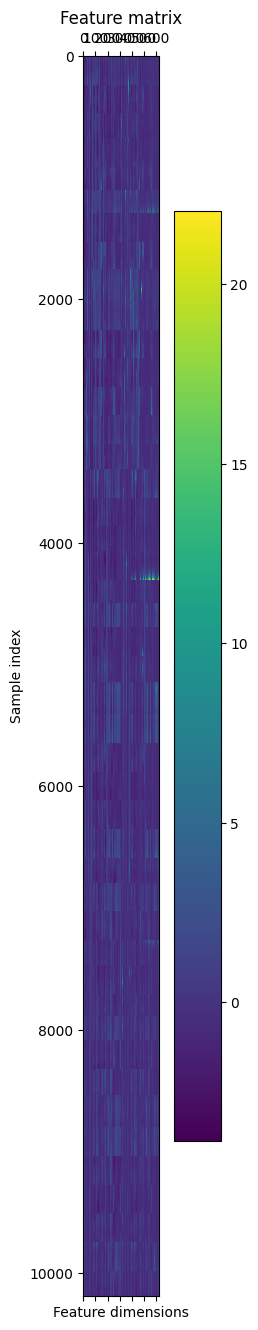

In [21]:
# GCAtrain2 + = pe, pf ablation
# Row max, mean without Self-similarity cp.cuda.Device(0).use()

args = get_seed_args()

device = get_device(args.bus_id, args.cuda_id[2])
setting_os_path(args.os_path)
# fix_random_variables(args.seed)


subject_de, subject_psd, subject_label, subject_sample_counts = load_subject_data(args.tensor_save_path, isdeap=False)

visualization_type = 1

args.tpe1 = 1.
args.tpe2 = 1.
args.tpf1 = 1.
args.tpf2 = 1.

for p in range(1,3):
    if p == 0:
        n_labels_by_trials = args.n_labels_by_trials3
    elif p == 1:
        n_labels_by_trials = args.n_labels_by_trials2
    else:
        n_labels_by_trials = args.n_labels_by_trials1

    best_epoch_list = []
    best_acc_list = []
    orig_acc_list = []

    print("========================================== SEED Protocol {} ==========================================".format(int(n_labels_by_trials*15)))

    for i in range(15):
        print("\n\n******************* SUBJECT : {} *********************".format(i+1))
        sub_idx = 'sub'+str(i+1)
        date = '230522'

        sub_de = subject_de[i]
        sub_psd = subject_psd[i]
        sub_label = subject_label[i]
        sub_sample_counts = subject_sample_counts[i]

        de,identifier = preprocessing(sub_de, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)
        psd,_ = preprocessing(sub_psd, sub_sample_counts, args.n_samples, n_labels_by_trials, args.n_nodes, args.n_features, args.seed)

        de = normalization(de, axis = 0, ntype='standardization')
        psd = normalization(psd, axis = 0, ntype='standardization')

        de_ssm, de_nssm = ssm_construction(de, args.n_samples, args.de_k)
        psd_ssm, psd_nssm = ssm_construction(psd, args.n_samples, args.psd_k)

        save_np(args.tensor_save_path+sub_idx, 'de_ssm_'+date, de_ssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_ssm_'+date, psd_ssm)
        save_np(args.tensor_save_path+sub_idx, 'de_nssm_'+date, de_nssm)
        save_np(args.tensor_save_path+sub_idx, 'psd_nssm_'+date, psd_nssm)
        save_heatmap(de_ssm, "DE SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_ssm, "PSD SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(de_nssm, "DE NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/DE_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')
        save_heatmap(psd_nssm, "PSD NSSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/ssm/PSD_NSSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        fsm = ssm_fusion(de_ssm,psd_ssm, de_nssm, psd_nssm, args.k1, args.t1)
        save_np(args.tensor_save_path+sub_idx, 'fused_ssm_'+date, fsm)
        save_heatmap(fsm, "Fused SSM", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/fused_ssm/Fused_SSM_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        adj = normalize_adj(fsm)
        save_np(args.tensor_save_path+sub_idx, 'adjacency_matrix_'+date, adj)
        save_heatmap(adj, "Normalized Adjacecy Matrix", "Sample indices (axis i)", "Sample indices (axis i)", args.figure_save_path+'heatmap/'+sub_idx+'/adjacency_matrix/Adjacecny_Matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight')

        feature = input_feature(de, psd)
        label = sub_label

        save_heatmap(feature, "Feature matrix", "Feature dimensions", "Sample index", args.figure_save_path+'heatmap/'+sub_idx+'/feature/feature_matrix_'+date+'.png',clim_min =None, clim_max =None, _dpi=300, _facecolor="#eeeeee", _bbox_inches = 'tight') 

        feature = torch.from_numpy(feature).to(torch.float32).to(device)
        adj = torch.from_numpy(adj).to(torch.float32).to(device)
        label = torch.from_numpy(label).to(torch.long).to(device)

        identifier = torch.from_numpy(identifier).bool()
        train_identifier = identifier.to(device)
        isunlabeled = ~identifier

        test_identifier = isunlabeled.to(device)

        activation = get_activation('celu')
        gcn = GraphConvolution

        encoder = Encoder(args.feature_dimension, args.gcn_hid_channels, args.gcn_out_channels, activation, args.seed, base_model = gcn).to(device)
        model = GRACE(encoder, args.feature_dimension, args.gcn_out_channels, args.proj_hid_channels, args.out_channels, args.ptau).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)

        best_acc, best_epoch, best_z, result = uniform_GCA_train(model, optimizer, feature, adj, label,
                                                                            train_identifier, test_identifier,
                                                                            args,device,date,sub_idx, isdeap=False)

        experiment_type = 'subject_dependent'
        model_save_name = sub_idx+'_model'
        model_path = args.model_save_path+experiment_type+'/'+date+'/'+model_save_name
        torch.save(model.state_dict(), model_path)

        print("*** Best ACC : {} ***".format(round(best_acc.item(), 2)))
        best_epoch_list.append(best_epoch)
        best_acc_list.append(round(best_acc.item(), 2))
        orig_acc_list.append(best_acc.item())


    #     sample = best_z.cpu().detach().numpy().copy()
    #     drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
    #     tsne_sample = StandardScaler().fit_transform(sample) # standardization
    #     dr_result = drmodel.fit_transform(tsne_sample)

    #     save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

    print("\n**************** Best acc by subject *********************")
    print("** Best ACC : {} **\n ** Avearge acc : {},    std : {} **\n".format(best_acc_list, round(np.mean(orig_acc_list),2), round(np.std(orig_acc_list),2)))


    print("\n Best Epochs : {}".format(best_epoch_list))
    best_acc_list = np.array(best_acc_list)
    save_np(args.tensor_save_path+sub_idx, 'protocol '+str(n_labels_by_trials)+'_best_acc_list_'+date, best_acc_list)


[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [122]:

visualization_type = 1
sample = best_z.cpu().detach().numpy().copy()
drmodel = TSNE(n_components = 2, perplexity = 50., n_iter_without_progress = 4000)
tsne_sample = StandardScaler().fit_transform(sample) # standardization
dr_result = drmodel.fit_transform(tsne_sample)


/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/neuroai/anaconda3/envs/py39_dh/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


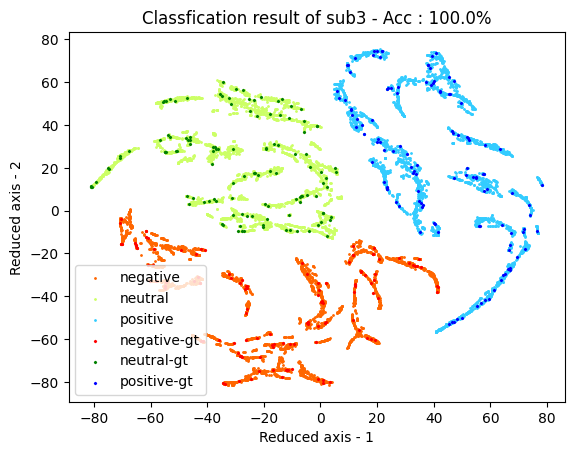

In [123]:
save_scatter(dr_result, label, best_acc.item(),sub_idx, date, args.figure_save_path, visualization_type, identifier)

In [120]:
def save_scatter(result, label, best_acc,sub_idx, date, save_path, dr_type, iden):

    negw = np.where(label.cpu()==0)[0]
    neuw = np.where(label.cpu()==1)[0]
    posw = np.where(label.cpu()==2)[0]
    if dr_type == 0:
        dr_name = 'PCA'
    elif dr_type == 1:
        dr_name = 'TSNE'
    else:
        dr_name = ''
    neg = result[negw]
    neu = result[neuw]
    pos = result[posw]

    gts = np.where(iden.cpu().numpy() ==True)[0]

    neggtw,neugtw,posgtw = [], [], []
    
    for i in gts:
        if i in negw:
            neggtw.append(i)
        elif i in neuw:
            neugtw.append(i)
        elif i in posw:
            posgtw.append(i)

    neggt = result[neggtw,:]
    neugt = result[neugtw,:]
    posgt = result[posgtw,:]
    
    plt.clf()
    c1 = plt.scatter(neg[:,0], neg[:,1], marker = "o", color='#FF6600',s=1.)
    gt1 = plt.scatter(neggt[:,0], neggt[:,1], marker = "x", color='red',s=2.)
    c2 = plt.scatter(neu[:,0], neu[:,1], marker = "o",color ='#CCFF66', s=1.)
    gt2 = plt.scatter(neugt[:,0], neugt[:,1], marker = "x", color='green',s=2.)
    c3 = plt.scatter(pos[:,0], pos[:,1], marker = "o",color ='#33CCFF', s=1.)
    gt3 = plt.scatter(posgt[:,0], posgt[:,1], marker = "x", color='blue',s=2.)
    
    plt.title('Classfication result of '+sub_idx + ' - Acc : '+ str(best_acc) +'%')
    plt.xlabel("Reduced axis - 1")
    plt.ylabel("Reduced axis - 2")
    plt.legend(handles = (c1,c2,c3, gt1,gt2,gt3),labels=("negative","neutral", "positive", "negative-gt", "neutral-gt", "positive-gt"))
    plt.savefig(save_path+'test_result/'+sub_idx+'/'+dr_name+'_classification_result_scatter_'+date+'.png', dpi=300, facecolor = "#eeeeee", bbox_inches = 'tight')
    return

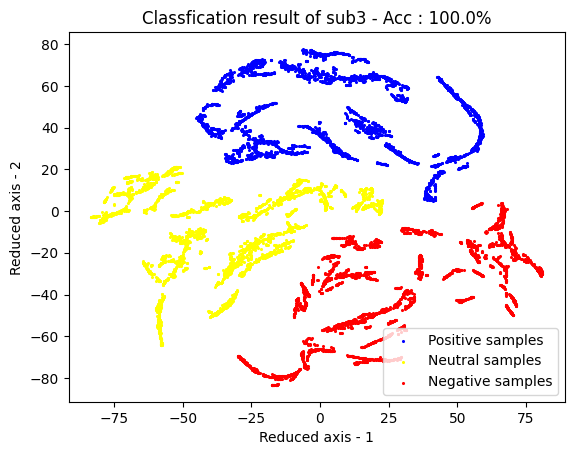